## Survival Data

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import sksurv
#import icd
from pandas import Series, DataFrame,cut
from pylab import rcParams
from numpy.random import default_rng
from numpy import arange
from sklearn import preprocessing
from sklearn import set_config
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE  
from sklearn.metrics import silhouette_score, davies_bouldin_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, OrdinalEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv

import scipy.optimize as opt
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from gap_statistic import OptimalK
from kmeans_numpy import KMeans_numpy
from collections import Counter
from matplotlib.pyplot import show

set_config(display="text")  # displays text representation of estimators
plt.rcParams['figure.figsize'] = [7.2, 4.8]

**Data: 500 subjects of the Worcester Heart Attack Study**

lenfol	: Total Length of Follow-up		Days from Hospital Admission Date to Date of Last Follow-up 
<br>
fstat	: Vital Status at Last Follow-up		0 = Alive 1 = Dead
<br>
age		: Age at Hospital Admission		Years
<br>
gender	: 0 = Male, 1 = Female
<br>
hr		: Initial Heart Rate			Beats per minute
<br>
sysbp	: Initial Systolic Blood Pressure 	mmHg
<br>
diasbp	: Initial Diastolic Blood Pressure	mmHg
<br>
bmi		: Body Mass Index			 	kg/m^2
<br>
cvd		: History of Cardiovascular Disease	0 = No, 1 = Yes
<br>
afb		: Atrial Fibrillation			0 = No, 1 = Yes
<br>
sho		: Cardiogenic Shock			0 = No, 1 = Yes
<br>
chf		: Congestive Heart Complications		0 = No, 1 = Yes
<br>
av3		: Complete Heart Block			0 = No, 1 = Yes
<br>
miord	: MI Order 				0 = First, 1 = Recurrent
<br>
mitype	:  MI Type 				0 = non Q-wave, 1 = Q-wave
<br>
year	: Cohort Year				1 = 1997, 2 = 1999, 3 = 2001
<br>
los		: Length of Hospital Stay			Days from Hospital Admission to Hospital Discharge
<br>
dstat	: Discharge Status from Hospital		0 = Alive, 1 = Dead

# Step 1. Processing/exploring data

In [4]:
address= 'whas500.csv'
pat = pd.read_csv(address)
pat.head()   

,ID,AGE,GENDER,HR,SYSBP,DIASBP,BMI,CVD,AFB,SHO,CHF,AV3,MIORD,MITYPE,YEAR,LOS,DSTAT,LENFOL,FSTAT
0,1,83,0,89,152,78,25.540510,1,1,0,0,0,1,0,1,5,0,2178,0
1,2,49,0,84,120,60,24.023979,1,0,0,0,0,0,1,1,5,0,2172,0
2,3,70,1,83,147,88,22.142900,0,0,0,0,0,0,1,1,5,0,2190,0
3,5,70,0,63,135,85,24.412550,1,0,0,0,0,0,1,1,6,0,2131,0
4,7,57,0,73,191,116,39.490459,1,0,0,0,0,0,1,1,5,0,2122,0


In [5]:
# change colum name from upper case to lower case
pat = pat.rename(columns=str.lower)

In [6]:
pat.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      500 non-null    int64  
 1   age     500 non-null    int64  
 2   gender  500 non-null    int64  
 3   hr      500 non-null    int64  
 4   sysbp   500 non-null    int64  
 5   diasbp  500 non-null    int64  
 6   bmi     500 non-null    float64
 7   cvd     500 non-null    int64  
 8   afb     500 non-null    int64  
 9   sho     500 non-null    int64  
 10  chf     500 non-null    int64  
 11  av3     500 non-null    int64  
 12  miord   500 non-null    int64  
 13  mitype  500 non-null    int64  
 14  year    500 non-null    int64  
 15  los     500 non-null    int64  
 16  dstat   500 non-null    int64  
 17  lenfol  500 non-null    int64  
 18  fstat   500 non-null    int64  
dtypes: float64(1), int64(18)
memory usage: 74.3 KB


### Checking missing rate

In [8]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n", pat.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 id        0
age       0
gender    0
hr        0
sysbp     0
diasbp    0
bmi       0
cvd       0
afb       0
sho       0
chf       0
av3       0
miord     0
mitype    0
year      0
los       0
dstat     0
lenfol    0
fstat     0
dtype: int64


In [9]:
pat['sysbp'].name='Systolic BP'
pat['diasbp'].name='Diastolic BP'
pat['hr'].name='Heart rate'
pat['dstat'].name='Discharge Status'
pat['miord'].name='Recurrent'
pat['mitype'].name='Q-Wave'

In [27]:
pat1=pat.copy(deep=True)
pat1['gender'].replace({0:'Male',1:'Female'},inplace=True)
def func(x):
    if x <21:
        return 1
    elif x<26:
        return 2
    elif x<31:
        return 3    
    return 4
pat1['bmi_bin'] = pat1['bmi'].apply(func)
pat1['age_bin'] = cut(pat1['age'], [0, 50, 60, 70, 80, float('inf')], labels=['<50', '50-60', '60-70', '70-80', '80+'])
pat1['gender'] = pat1['gender'].astype('category')
pat1['bmi_bin'] = pat1['bmi_bin'].astype('category')
pat1.drop(['id', 'bmi', 'age'], axis=1, inplace=True)
pat1.head()

,gender,hr,sysbp,diasbp,cvd,afb,sho,chf,av3,miord,mitype,year,los,dstat,lenfol,fstat,bmi_bin,age_bin
0,Male,89,152,78,1,1,0,0,0,1,0,1,5,0,2178,0,2,80+
1,Male,84,120,60,1,0,0,0,0,0,1,1,5,0,2172,0,2,<50
2,Female,83,147,88,0,0,0,0,0,0,1,1,5,0,2190,0,2,60-70
3,Male,63,135,85,1,0,0,0,0,0,1,1,6,0,2131,0,2,60-70
4,Male,73,191,116,1,0,0,0,0,0,1,1,5,0,2122,0,4,50-60


In [28]:
bc_x=pat1.drop(['fstat', 'lenfol'], axis=1)

In [12]:
num_feat=['lenfol', 'age', 'hr', 'sysbp', 'diasbp', 'bmi', 'los']
cat_feat=['fstat', 'gender', 'cvd', 'afb', 'sho', 'chf', 'av3', 'miord', 'mitype', 'year', 'dstat']
num_feat_short=['age', 'hr', 'sysbp', 'diasbp', 'bmi', 'los']
num_feat_short2=['hr', 'sysbp', 'diasbp', 'bmi', 'los']
bc_num=pat[num_feat]
bc_num_short=pat[num_feat_short]
bc_num_short2=pat[num_feat_short2]
bc_cat=pat[cat_feat]

In [13]:
pd.options.display.float_format = '{:.2f}'.format
bc_num.describe()

,lenfol,age,hr,sysbp,diasbp,bmi,los
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,882.44,69.85,87.02,144.70,78.27,26.61,6.12
std,705.67,14.49,23.59,32.29,21.55,5.41,4.71
min,1.00,30.00,35.00,57.00,6.00,13.05,0.00
25%,296.50,59.00,69.00,123.00,63.00,23.22,3.00
50%,631.50,72.00,85.00,141.50,79.00,25.95,5.00
75%,1363.50,82.00,100.25,164.00,91.25,29.39,7.00
max,2358.00,104.00,186.00,244.00,198.00,44.84,47.00


**Numeric features, different by status of survival**

In [60]:
pat.groupby('fstat')[num_feat].mean()

,lenfol,age,hr,sysbp,diasbp,bmi,los
fstat,,,,,,,
0,1227.79,63.73,81.71,146.80,81.79,27.92,5.79
1,424.64,77.95,94.05,141.93,73.60,24.89,6.54


**Interpretation**

- lenfol: dead patients (fstat=1) had significantly shorter length of Follow-up Days 
- age: dead patients were older
- hr: dead patients had higher heart rates

### Plot continuous features

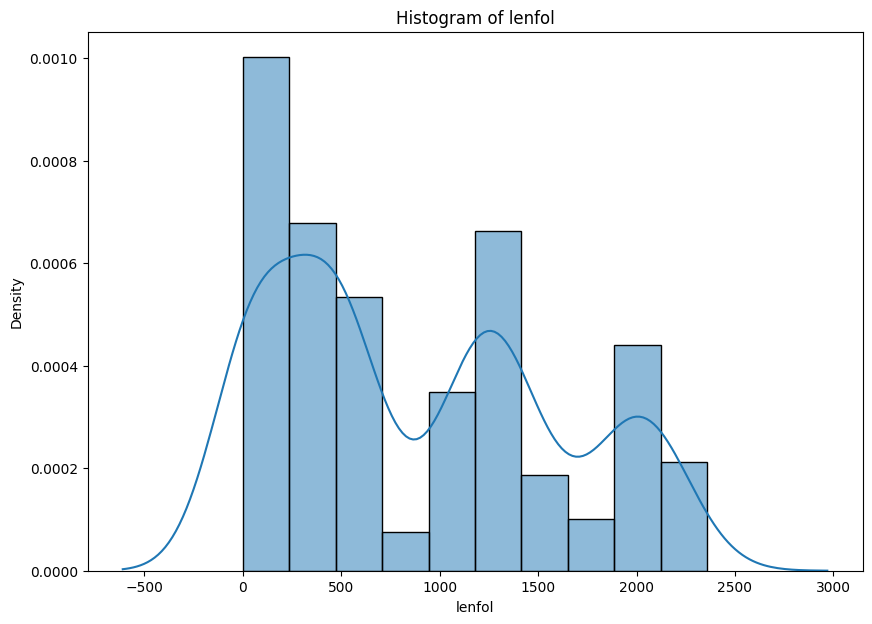

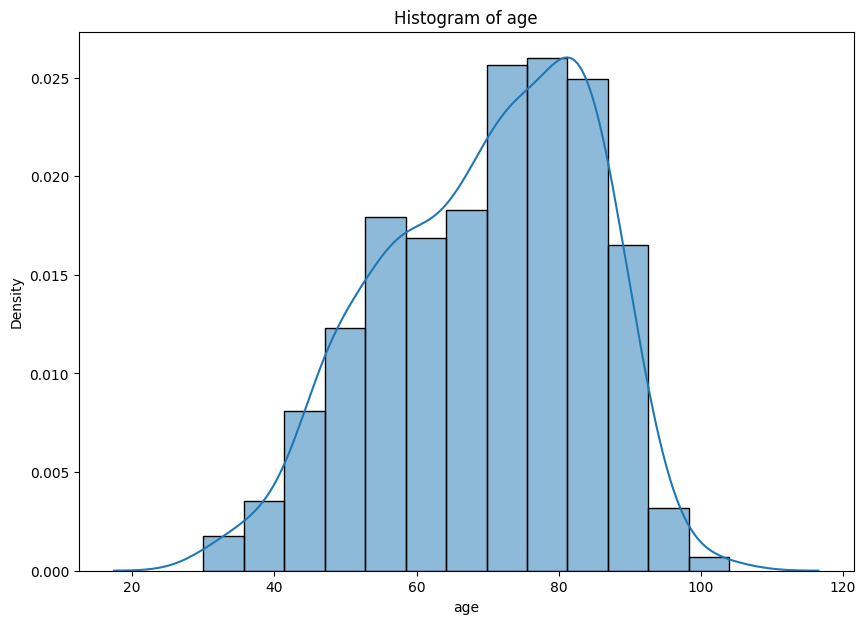

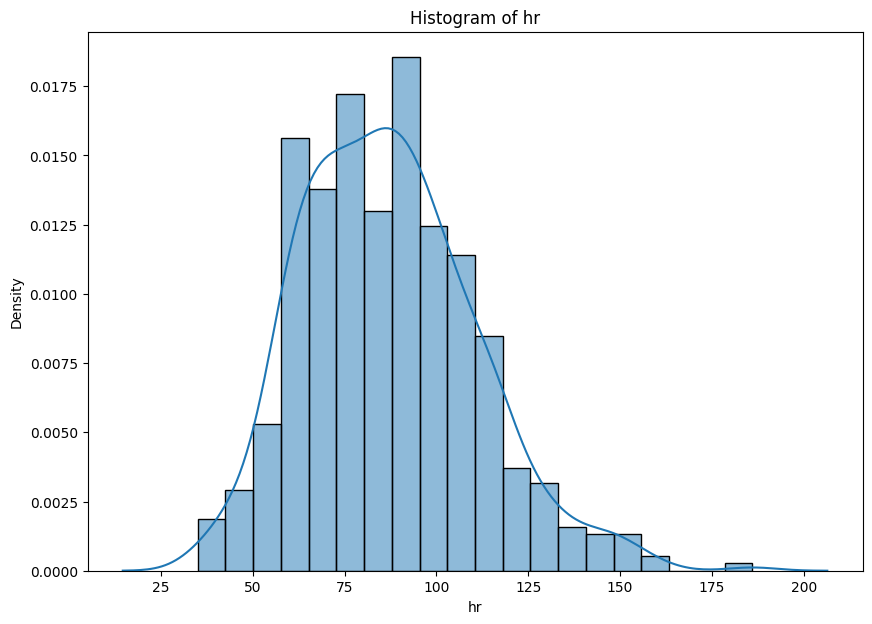

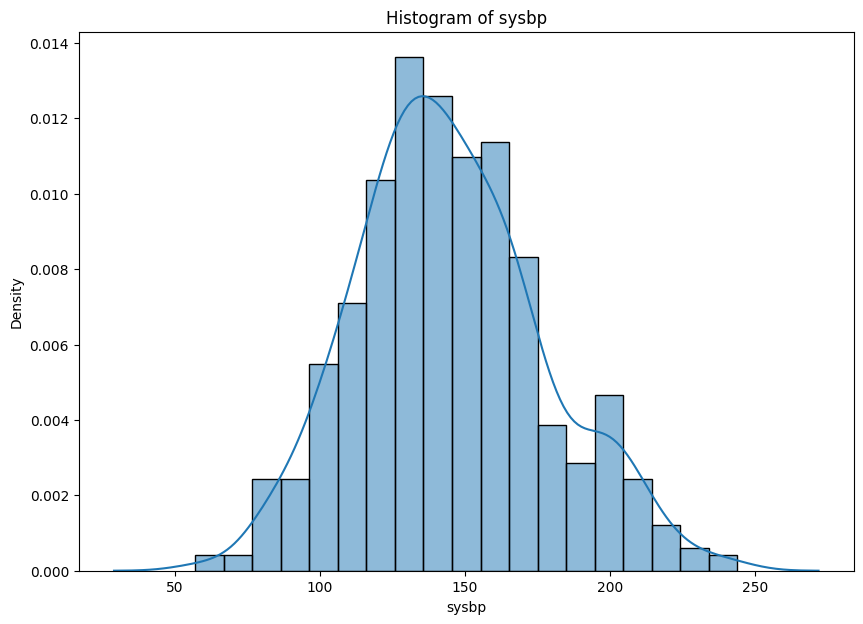

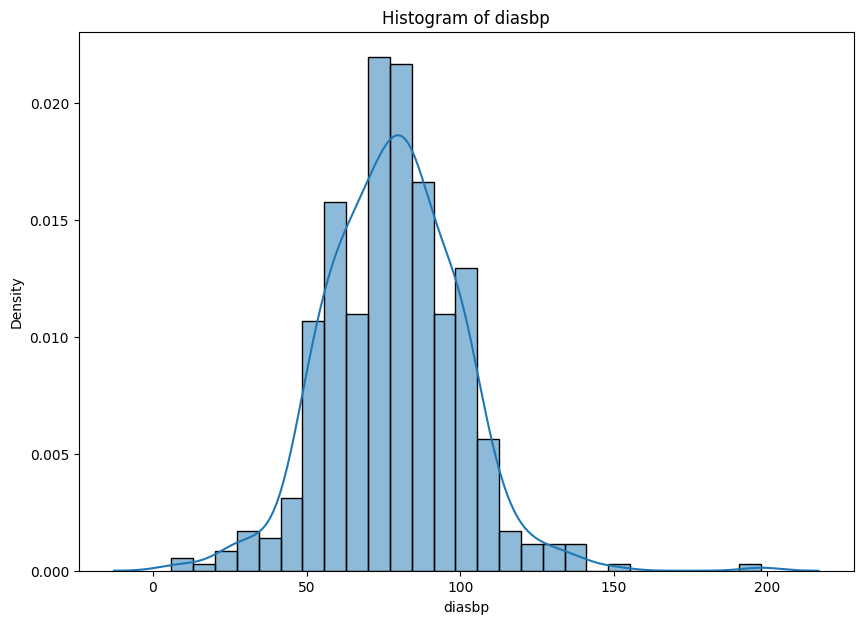

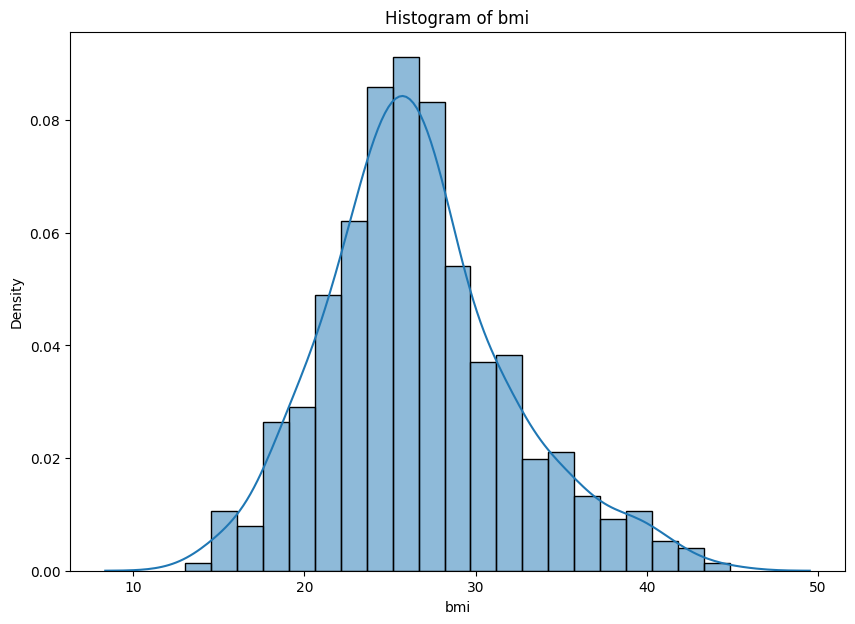

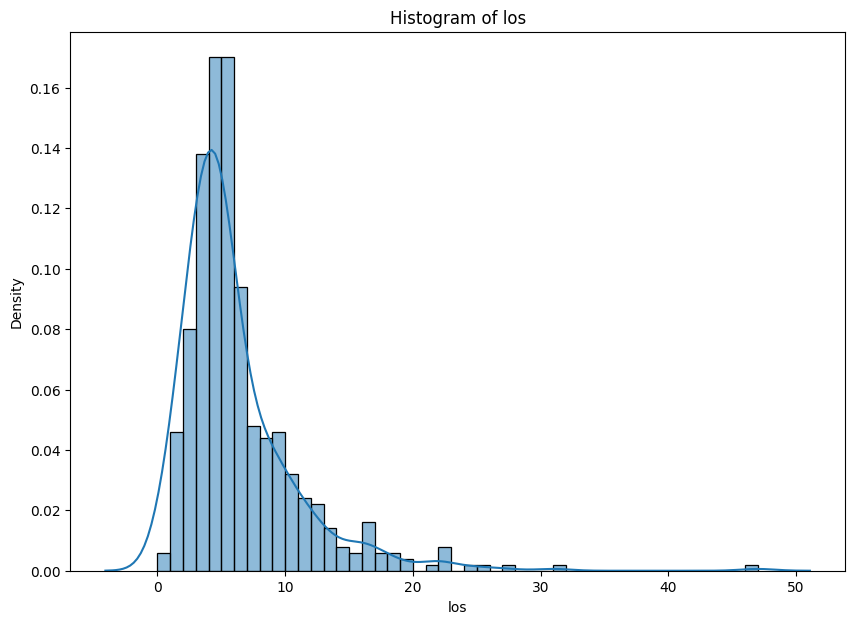

In [14]:
# Single histogram & Kernel density together
for col in num_feat:
    plt.rcParams['figure.figsize'] = (10, 7)
    sns.histplot(data=pat, x=col, kde=True, stat="density", kde_kws=dict(cut=3))
    plt.title('Histogram of '+col)
    plt.show()

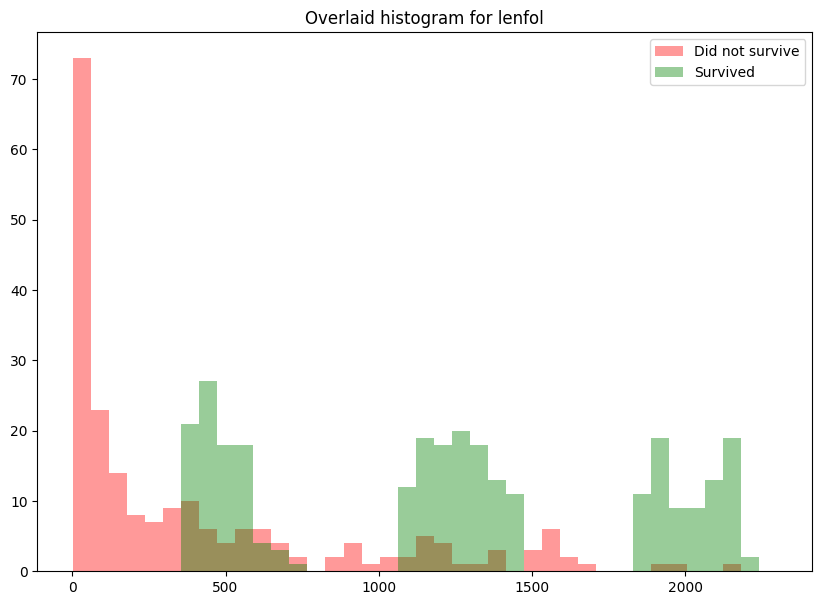

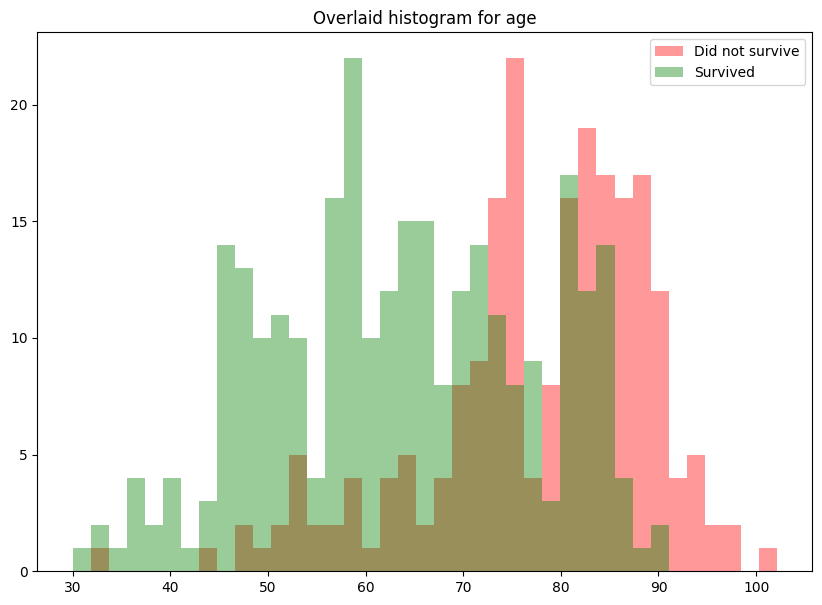

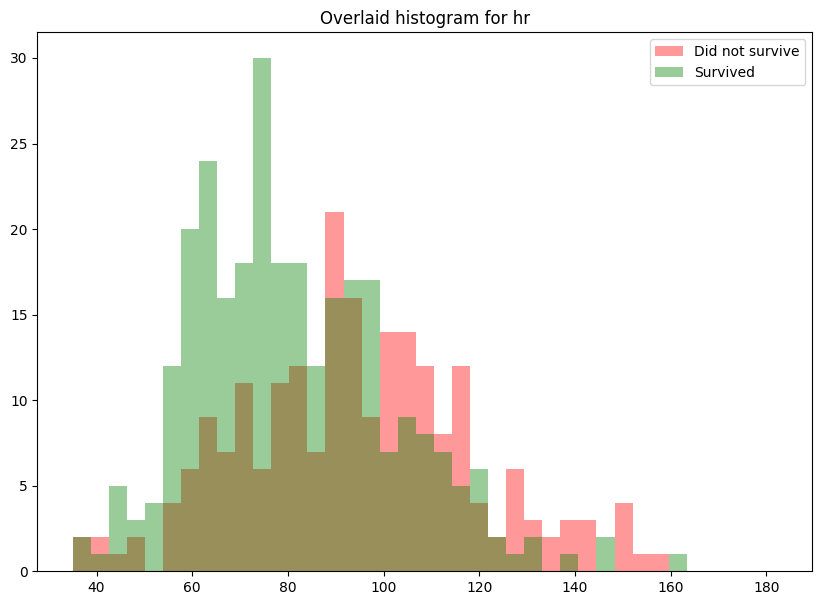

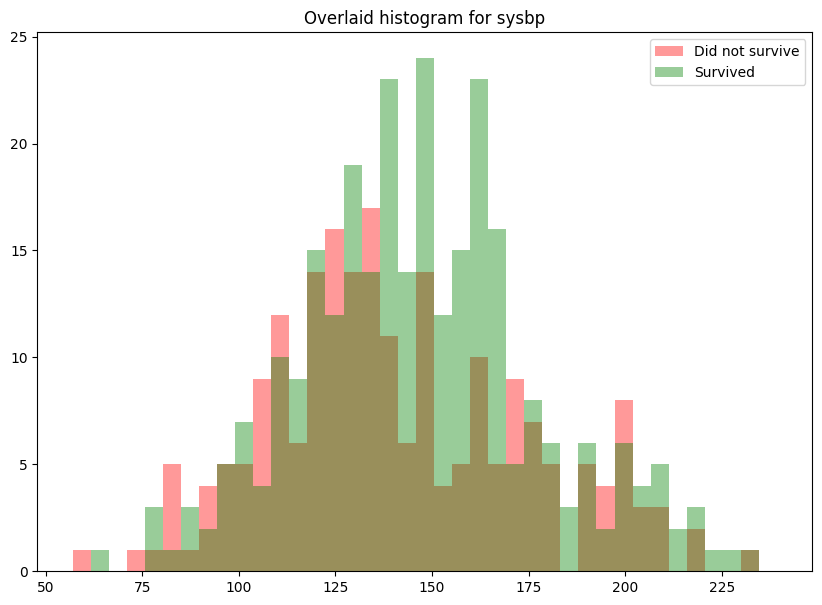

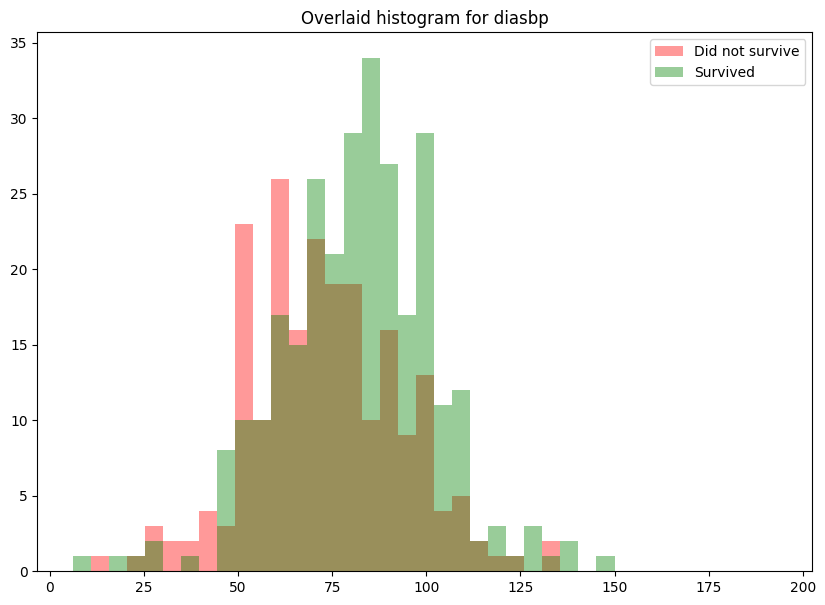

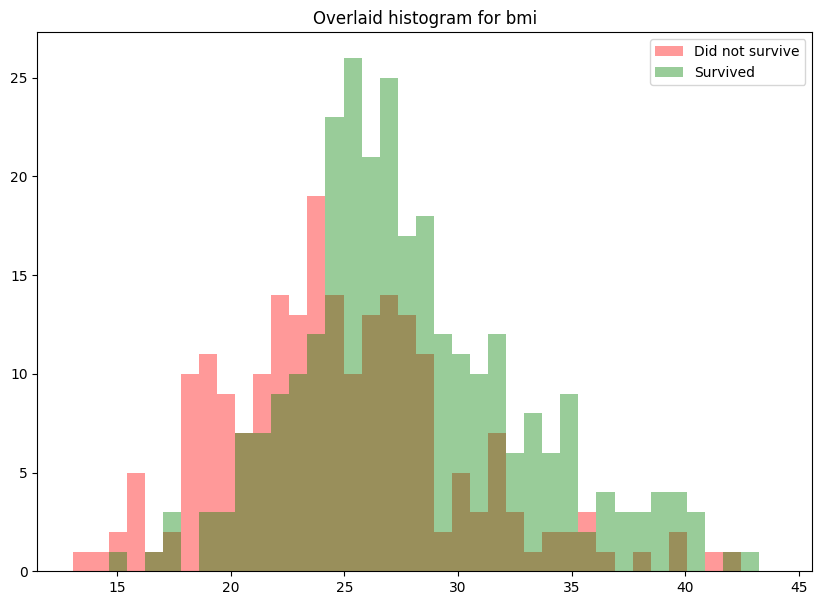

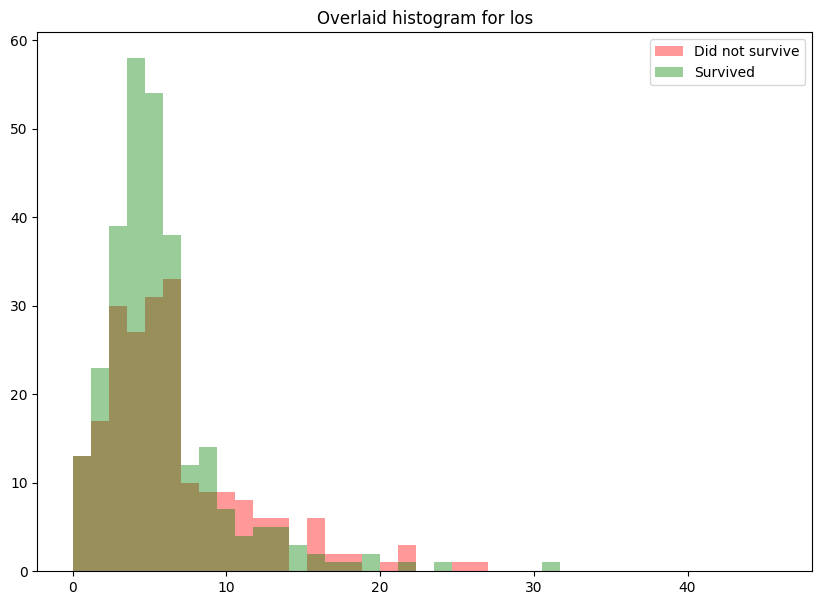

In [16]:
for i in num_feat:
    survived = list(pat[pat['fstat'] == 0][i].dropna())  # drop rows w/ missing
    died = list(pat[pat['fstat'] == 1][i].dropna())
    xmin = min(min(died), min(survived))                        # def. of min of x-axis
    xmax = max(max(died), max(survived))                        # def. of max of x-axis
    width = (xmax - xmin) / 40                                  # def. of width of histogram
    sns.distplot(died, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(survived, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Did not survive', 'Survived'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

### Scatter plot of numeric features

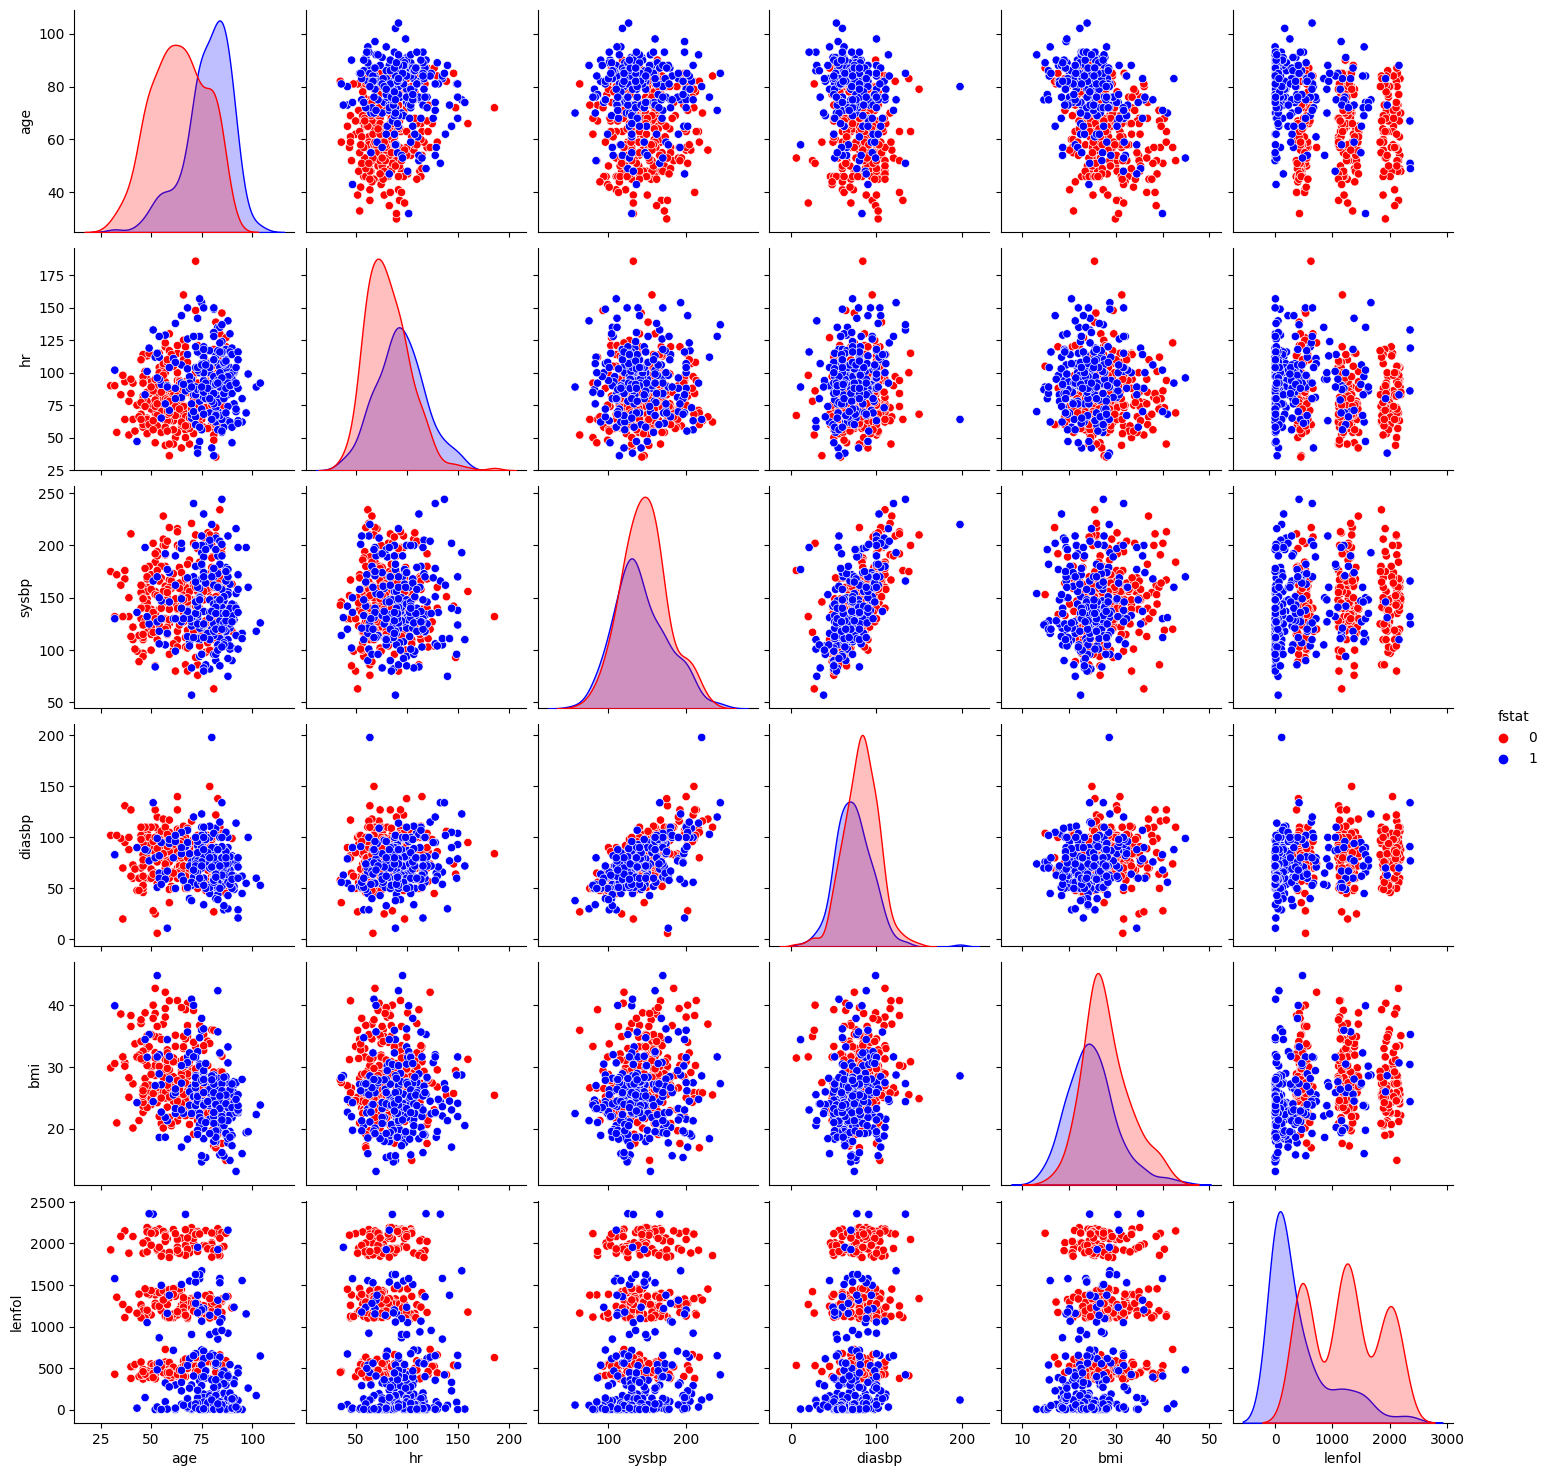

In [46]:
#Scatter plot by target
temp=pat[['age', 'hr', 'sysbp', 'diasbp', 'bmi', 'lenfol', 'fstat']]
temp=bc_num+pat[['fstat']]
plt.rcParams['figure.figsize'] = (15, 15)
sns.pairplot(temp, hue='fstat', palette=["red", "blue"])   

### Frequency table of categorical features

In [36]:
for col in cat_feat:
    df=pd.concat([pat[col].value_counts(), pat[col].value_counts(normalize=True).mul(100)], axis=1, keys=["Count", "%"])
    print("\n" + col) 
    print(df)


fstat
   Count     %
0    285  57.0
1    215  43.0

gender
   Count     %
0    300  60.0
1    200  40.0

cvd
   Count     %
1    375  75.0
0    125  25.0

afb
   Count     %
0    422  84.4
1     78  15.6

sho
   Count     %
0    478  95.6
1     22   4.4

chf
   Count     %
0    345  69.0
1    155  31.0

av3
   Count     %
0    489  97.8
1     11   2.2

miord
   Count     %
0    329  65.8
1    171  34.2

mitype
   Count     %
0    347  69.4
1    153  30.6

year
   Count     %
2    188  37.6
1    160  32.0
3    152  30.4

dstat
   Count     %
0    461  92.2
1     39   7.8


### Bar chart of categorical features

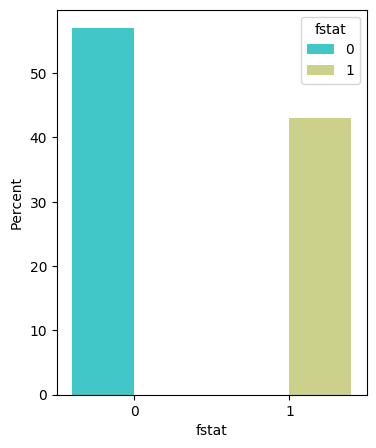

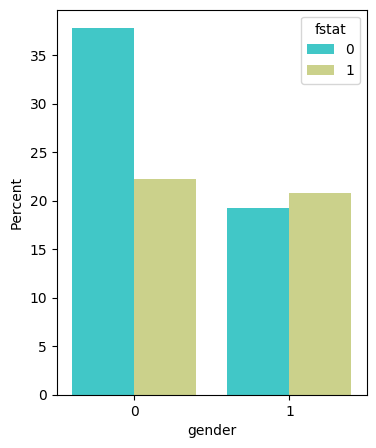

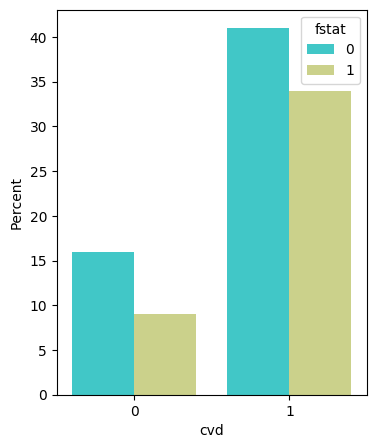

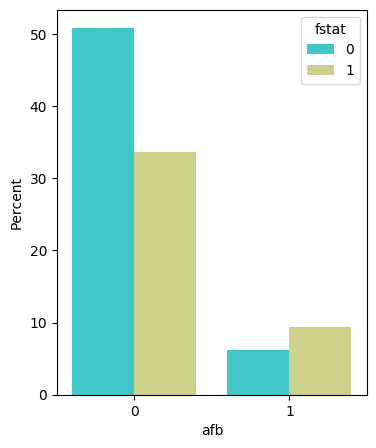

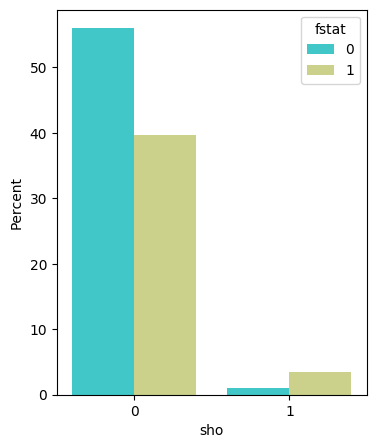

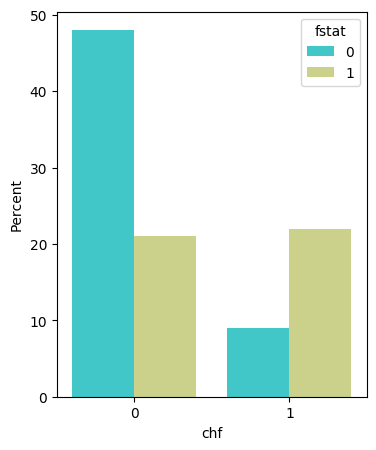

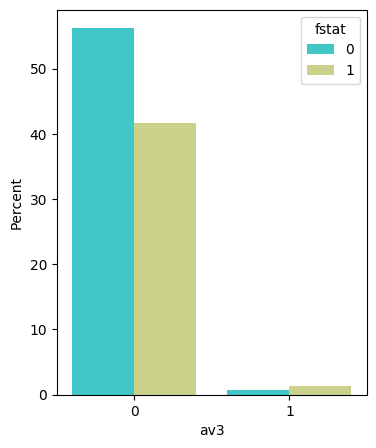

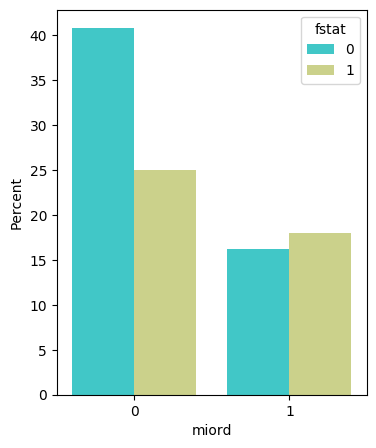

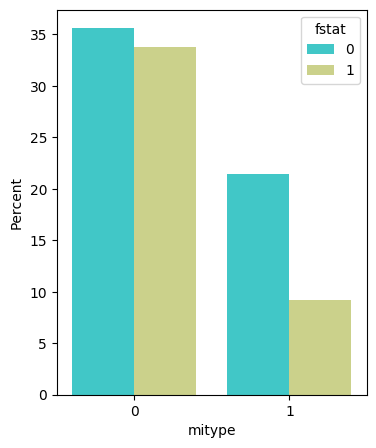

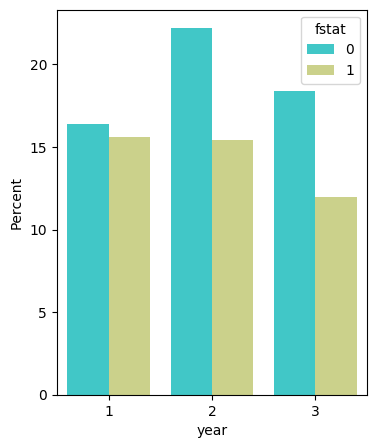

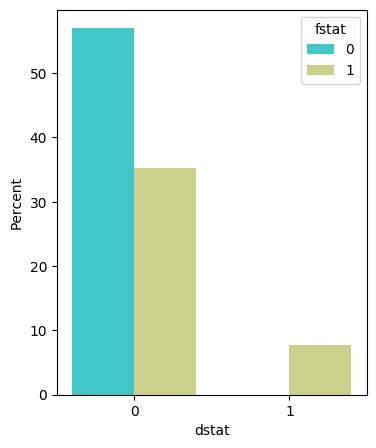

In [38]:
for col in cat_feat:
    # setting the dimensions of the plot
    fig, ax = plt.subplots(figsize=(4, 5))
    ax = sns.barplot(x=col, y=col, hue='fstat', data=pat, estimator=lambda x: len(x) / len(pat) * 100, palette='rainbow')
    ax.set(ylabel="Percent")
    plt.show()

### Cross table  (No of obs.) between categorical features and survival status (fstat)

In [61]:
for feature in cat_feat:
    display(pd.crosstab(index=pat[feature], columns=pat['fstat'], margins=True, margins_name="Total"))

fstat,0,1,Total
fstat,,,
0,285,0,285
1,0,215,215
Total,285,215,500


fstat,0,1,Total
gender,,,
0,189,111,300
1,96,104,200
Total,285,215,500


fstat,0,1,Total
cvd,,,
0,80,45,125
1,205,170,375
Total,285,215,500


fstat,0,1,Total
afb,,,
0,254,168,422
1,31,47,78
Total,285,215,500


fstat,0,1,Total
sho,,,
0,280,198,478
1,5,17,22
Total,285,215,500


fstat,0,1,Total
chf,,,
0,240,105,345
1,45,110,155
Total,285,215,500


fstat,0,1,Total
av3,,,
0,281,208,489
1,4,7,11
Total,285,215,500


fstat,0,1,Total
miord,,,
0,204,125,329
1,81,90,171
Total,285,215,500


fstat,0,1,Total
mitype,,,
0,178,169,347
1,107,46,153
Total,285,215,500


fstat,0,1,Total
year,,,
1,82,78,160
2,111,77,188
3,92,60,152
Total,285,215,500


fstat,0,1,Total
dstat,,,
0,285,176,461
1,0,39,39
Total,285,215,500


### Percent of Cross table between categorical features and survival status (fstat)

In [62]:
#% of cross tab
for feature in cat_feat:
    display(pd.crosstab(index=pat[feature], columns=pat['fstat'], normalize=True, margins=True, margins_name="Total"))

fstat,0,1,Total
fstat,,,
0,0.57,0.00,0.57
1,0.00,0.43,0.43
Total,0.57,0.43,1.00


fstat,0,1,Total
gender,,,
0,0.38,0.22,0.60
1,0.19,0.21,0.40
Total,0.57,0.43,1.00


fstat,0,1,Total
cvd,,,
0,0.16,0.09,0.25
1,0.41,0.34,0.75
Total,0.57,0.43,1.00


fstat,0,1,Total
afb,,,
0,0.51,0.34,0.84
1,0.06,0.09,0.16
Total,0.57,0.43,1.00


fstat,0,1,Total
sho,,,
0,0.56,0.40,0.96
1,0.01,0.03,0.04
Total,0.57,0.43,1.00


fstat,0,1,Total
chf,,,
0,0.48,0.21,0.69
1,0.09,0.22,0.31
Total,0.57,0.43,1.00


fstat,0,1,Total
av3,,,
0,0.56,0.42,0.98
1,0.01,0.01,0.02
Total,0.57,0.43,1.00


fstat,0,1,Total
miord,,,
0,0.41,0.25,0.66
1,0.16,0.18,0.34
Total,0.57,0.43,1.00


fstat,0,1,Total
mitype,,,
0,0.36,0.34,0.69
1,0.21,0.09,0.31
Total,0.57,0.43,1.00


fstat,0,1,Total
year,,,
1,0.16,0.16,0.32
2,0.22,0.15,0.38
3,0.18,0.12,0.30
Total,0.57,0.43,1.00


fstat,0,1,Total
dstat,,,
0,0.57,0.35,0.92
1,0.00,0.08,0.08
Total,0.57,0.43,1.00


### Set up survival target variables: structured array for scikit**

status: boolen

survial days: numeric

In [22]:
bc_y= pat[['fstat', 'lenfol']].to_numpy()
aux = [(fstat,lenfol) for fstat,lenfol in bc_y]
#Structured array
bcy = np.array(aux, dtype=[('fstat', bool), ('lenfol', float)])
bcy

array([(False, 2.178e+03), (False, 2.172e+03), (False, 2.190e+03),
       (False, 2.131e+03), (False, 2.122e+03), (False, 2.175e+03),
       (False, 2.173e+03), (False, 2.192e+03), (False, 2.166e+03),
       (False, 2.168e+03), (False, 2.146e+03), (False, 2.114e+03),
       (False, 2.132e+03), (False, 2.139e+03), (False, 2.048e+03),
       (False, 2.152e+03), (False, 2.156e+03), (False, 2.064e+03),
       (False, 2.057e+03), (False, 2.151e+03), (False, 2.065e+03),
       (False, 2.048e+03), (False, 2.118e+03), (False, 2.113e+03),
       (False, 2.032e+03), (False, 2.126e+03), (False, 2.126e+03),
       (False, 2.123e+03), (False, 2.009e+03), (False, 1.994e+03),
       (False, 1.993e+03), (False, 1.955e+03), (False, 1.964e+03),
       (False, 1.976e+03), (False, 2.009e+03), (False, 1.942e+03),
       (False, 2.006e+03), (False, 2.086e+03), (False, 1.969e+03),
       (False, 1.939e+03), (False, 1.939e+03), (False, 1.940e+03),
       (False, 1.941e+03), (False, 1.933e+03), (False, 2.084e+

In [23]:
#check 5 rows of numpy array
bcy[: 5]

array([(False, 2178.), (False, 2172.), (False, 2190.), (False, 2131.),
       (False, 2122.)], dtype=[('fstat', '?'), ('lenfol', '<f8')])

### Check correlation

In [29]:
matrix = pat1.corr().round(2)
matrix2 = matrix.unstack()
matrix2= matrix2[(abs(matrix2)>=0.7) & (abs(matrix2) < 1)]
matrix2

Series([], dtype: float64)

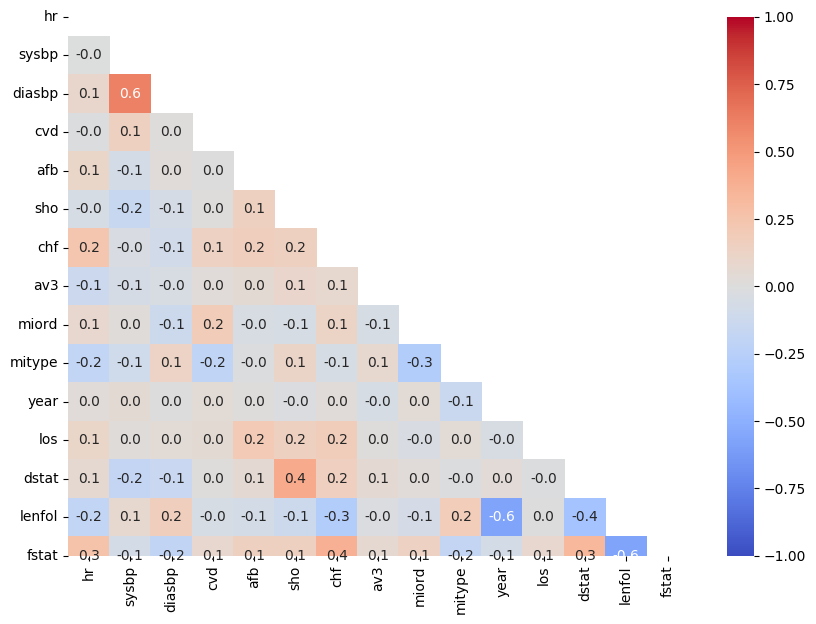

In [31]:
# Generate correlation matrix heat map
mask = np.triu(pat1.corr())
sns.heatmap(pat1.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap='coolwarm', mask=mask)

**Interpretation:** no correlation

# Step 2. Survival Analysis

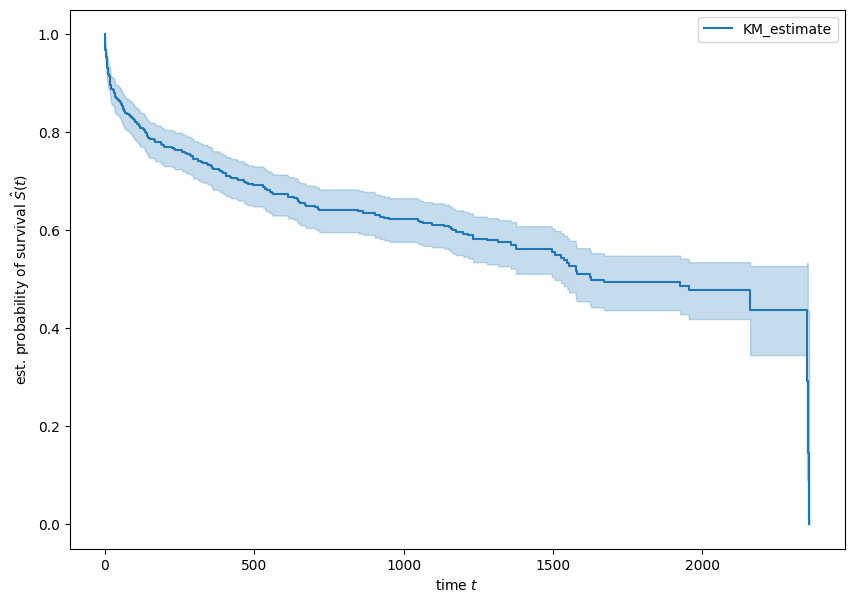

In [33]:
from lifelines import KaplanMeierFitter, CoxPHFitter
T=pat1['lenfol']
E=pat1['fstat']
kmf=KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E)
kmf.plot_survival_function()
plt.ylabel('est. probability of survival $\hat{S}(t)$')
plt.xlabel('time $t$');

In [34]:
from lifelines.utils import median_survival_times
median_=kmf.median_survival_time_
median_confidence_interval_=median_survival_times(kmf.confidence_interval_)
print("Median Survival Time:", median_)
print("\nMedian Survival Time:\n", median_confidence_interval_)

Median Survival Time: 1627.0

Median Survival Time:
       KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.50                 1506.00                 2353.00


## Kaplan-Meier survival functions by gender

In [91]:
bc_x['gender'].value_counts(sort=True, ascending=False, dropna=False)

Male      300
Female    200
Name: gender, dtype: int64

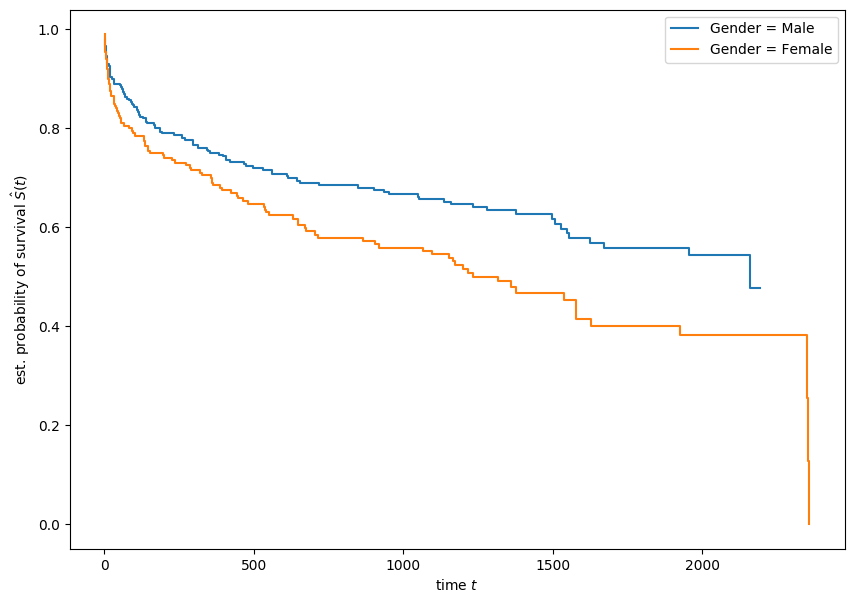

In [35]:
for type in ('Male', 'Female'):
    mask_sex = bc_x['gender'] == type
    sex, survival_prob_sex = kaplan_meier_estimator(
    bcy['fstat'][mask_sex],
    bcy['lenfol'][mask_sex])
    plt.step(sex, survival_prob_sex, where='post', 
            label = 'Gender = %s' % type)
    
plt.ylabel('est. probability of survival $\hat{S}(t)$')
plt.xlabel('time $t$')
plt.legend(loc='best');

## Kaplan-Meier survival functions by BMI

In [36]:
bc_x['bmi_bin'].value_counts(sort=True, ascending=False, dropna=False)

2    187
3    150
4     96
1     67
Name: bmi_bin, dtype: int64

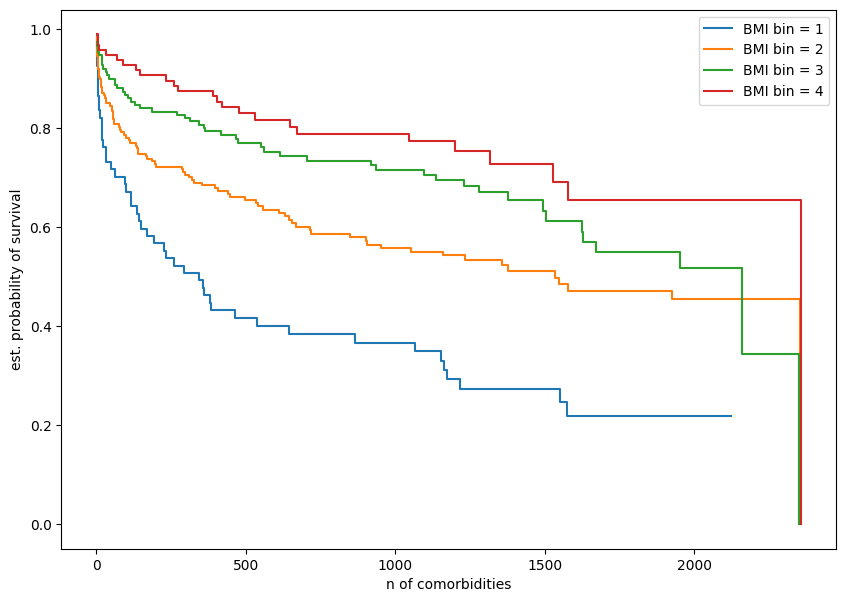

In [37]:
for val in range (1, 5):
    mask_bmi = bc_x['bmi_bin'] ==val
    bmi, survival_prob_bmi = kaplan_meier_estimator(
    bcy['fstat'][mask_bmi],
    bcy['lenfol'][mask_bmi])
    plt.step(bmi, survival_prob_bmi, where='post', 
            label = 'BMI bin = %s' % val)
    
plt.ylabel('est. probability of survival')
plt.xlabel('n of comorbidities')
plt.legend(loc='best');

## Kaplan-Meier survival functions by age

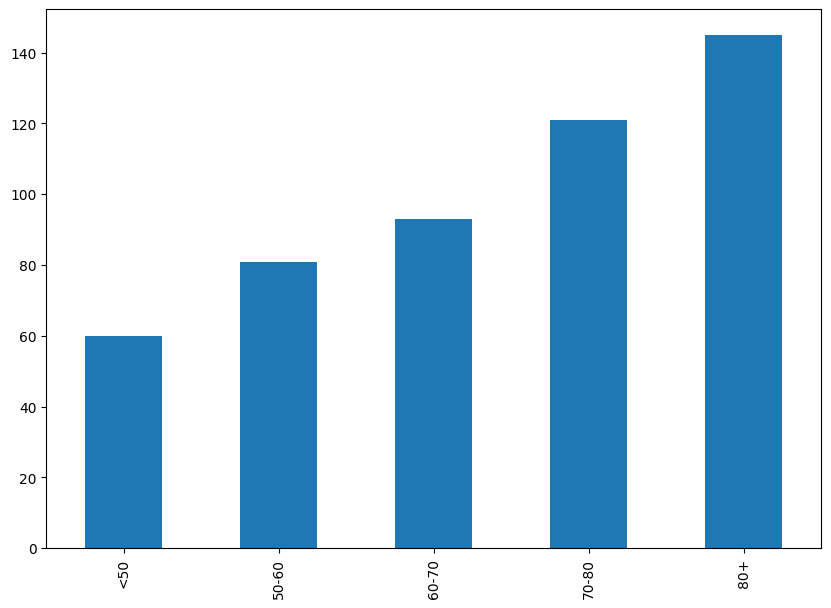

In [38]:
bc_x['age_bin'].value_counts().sort_index().plot.bar()

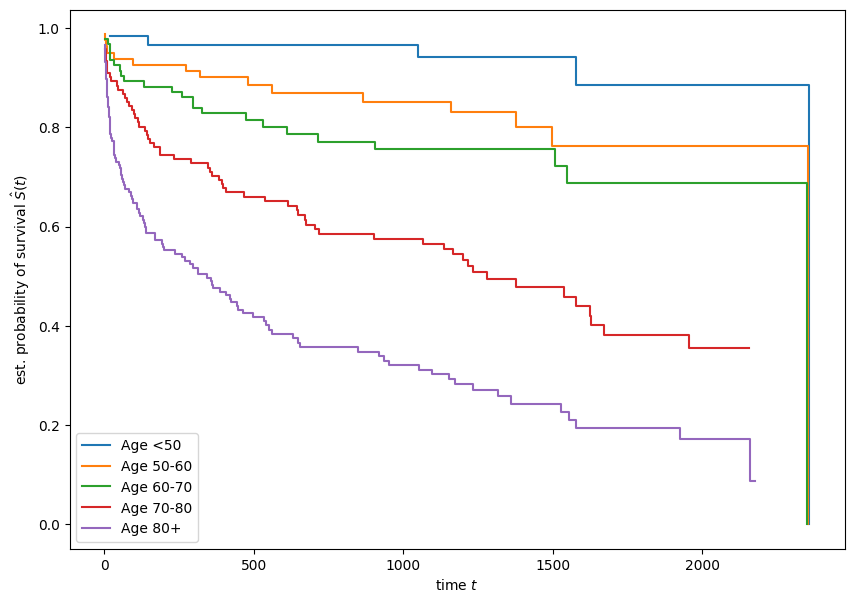

In [39]:
for type in ('<50', '50-60', '60-70', '70-80', '80+'):
    mask_age = bc_x['age_bin'] == type
    age, survival_prob_age = kaplan_meier_estimator(
    bcy['fstat'][mask_age],
    bcy['lenfol'][mask_age])
    plt.step(age, survival_prob_age, where='post', 
            label = 'Age '+type)
    
plt.ylabel('est. probability of survival $\hat{S}(t)$')
plt.xlabel('time $t$')
plt.legend(loc='best');

## Multivariate Survival Models-Cox regression

In [43]:
pat2= OneHotEncoder().fit_transform(pat1)

In [47]:
pat2.rename(columns={"gender=Male": "male", "bmi_bin=2": "c_bmi2", "bmi_bin=3":"c_bmi3", "bmi_bin=4":"c_bmi4", 
                      "age_bin=50-60":"c_age56", "age_bin=60-70":"c_age67", "age_bin=70-80":"c_age78", 
                      "age_bin=80+":"c_age8+"}, inplace=True)

In [48]:
cph=CoxPHFitter()
cph.fit(pat2, duration_col='lenfol', event_col='fstat')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 500 total observations, 285 right-censored observations>
             duration col = 'lenfol'
                event col = 'fstat'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 215
   partial log-likelihood = -1025.64
         time fit was run = 2023-01-29 03:07:29 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
male        0.49       1.63       0.15             0.19             0.79                 1.21                 2.21
hr          0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
sysbp       0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
diasbp     -0.01       0.99       0.01            -0.02            -0.00                 0.98                 1.00
cvd         0.02       1.02       0.18            -0.34             0.38                 0.71                 1.47
afb         0.18       1.19       0.18            -0.17             0.53                 0.84                 1.70
sho        -0.30       0.74       0.32            -0.92             0.33                 0.40                 1.40
chf         0.74       2.09       0.16             0.43             1.04                 1.54                 2.84
av3         0.66       1.93       0.43            -0.19             1.51                 0.83                 4.52
miord       0.03       1.03       0.15            -0.27             0.32                 0.76                 1.38
mitype     -0.11       0.89       0.19            -0.49             0.27                 0.61                 1.31
year        0.22       1.25       0.10             0.02             0.42                 1.02                 1.53
los        -0.05       0.95       0.02            -0.08            -0.01                 0.92                 0.99
dstat       4.81     122.43       0.42             3.98             5.63                53.53               280.00
c_bmi2     -0.64       0.53       0.19            -1.01            -0.27                 0.36                 0.77
c_bmi3     -0.69       0.50       0.21            -1.11            -0.27                 0.33                 0.76
c_bmi4     -0.62       0.54       0.28            -1.16            -0.08                 0.31                 0.92
c_age56     1.06       2.88       0.57            -0.06             2.18                 0.94                 8.84
c_age67     1.48       4.38       0.56             0.39             2.57                 1.47                13.03
c_age78     2.04       7.73       0.54             0.99             3.10                 2.68                22.27
c_age8+     2.50      12.15       0.55             1.43             3.57                 4.17                35.40

            cmp to     z      p   -log2(p)
covariate                                 
male          0.00  3.21 <0.005       9.56
hr            0.00  3.46 <0.005      10.84
sysbp         0.00  1.08   0.28       1.84
diasbp        0.00 -2.66   0.01       7.00
cvd           0.00  0.12   0.90       0.15
afb           0.00  0.99   0.32       1.62
sho           0.00 -0.92   0.36       1.49
chf           0.00  4.72 <0.005      18.67
av3           0.00  1.52   0.13       2.97
miord         0.00  0.18   0.86       0.22
mitype        0.00 -0.58   0.57       0.82
year          0.00  2.14   0.03       4.96
los           0.00 -2.59   0.01       6.72
dstat         0.00 11.39 <0.005      97.43
c_bmi2        0.00 -3.35 <0.005      10.27
c_bmi3        0.00 -3.23 <0.005       9.64
c_bmi4        0.00 -2.26   0.02       5.40
c_age56       0.00  1.85   0.06       3.97
c_age67       0.00  2.66   0.01       6.98
c_age78       0.00  3.79 <0.005      12.68
c_age8+       0.00  4.58 <0.005      17.71
---
C

In [49]:
bcx=pat2.drop(['fstat', 'lenfol'], axis=1)

**Check correlation**

In [46]:
matrix = bcx.corr().round(2)
matrix2 = matrix.unstack()
matrix2= matrix2[(abs(matrix2)>=0.7) & (abs(matrix2) < 1)]
matrix2

Series([], dtype: float64)

**Using the fitted model, predict a patient-specific survival**

for four synthetic patients

In [54]:
x_new = pd.DataFrame.from_dict({
    1: [1, 89, 152, 78, 1, 1, 0, 0, 0, 1, 0, 1, 5, 0, 1, 0, 0, 0, 0, 0, 1],
    2: [1, 84, 120, 60, 1, 0, 0, 0, 0, 0, 1, 1, 5, 0, 1, 0, 0, 0, 0, 0, 0], 
    3: [0, 83, 147, 88, 0, 0, 0, 0, 0, 0, 1, 1, 5, 0, 1, 0, 0, 0, 1, 0, 0],
    4: [1, 63, 135, 85, 1, 0, 0, 0, 0, 0, 1, 1, 6, 0, 1, 0, 0, 0, 1, 0, 0]}, 
     columns=bcx.columns, orient='index')
x_new

,male,hr,sysbp,diasbp,cvd,afb,sho,chf,av3,miord,...,year,los,dstat,c_bmi2,c_bmi3,c_bmi4,c_age56,c_age67,c_age78,c_age8+
1,1,89,152,78,1,1,0,0,0,1,...,1,5,0,1,0,0,0,0,0,1
2,1,84,120,60,1,0,0,0,0,0,...,1,5,0,1,0,0,0,0,0,0
3,0,83,147,88,0,0,0,0,0,0,...,1,5,0,1,0,0,0,1,0,0
4,1,63,135,85,1,0,0,0,0,0,...,1,6,0,1,0,0,0,1,0,0


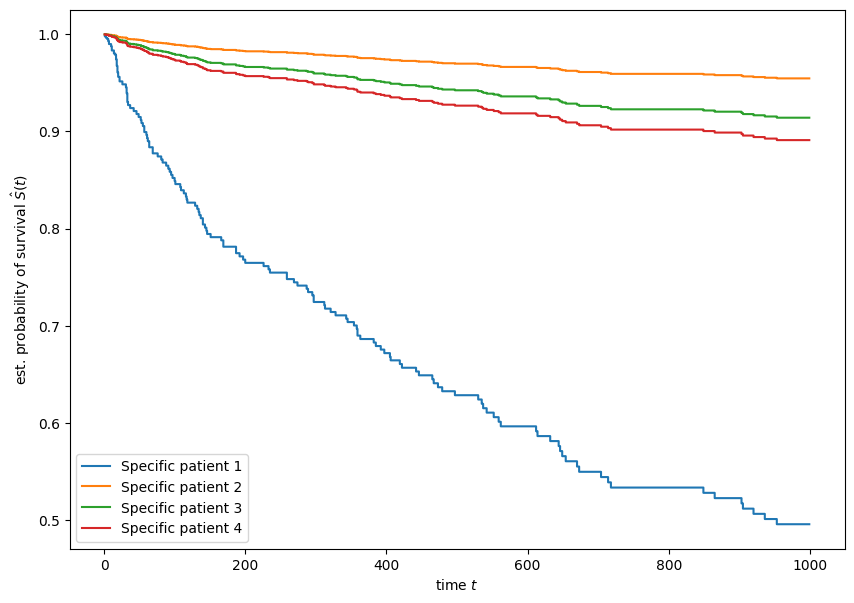

In [56]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(bcx, bcy)
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)

for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where='post', 
            label='Specific patient %d' % (i+1))
plt.ylabel('est. probability of survival $\hat{S}(t)$')
plt.xlabel('time $t$')
plt.legend(loc='best');

## Feature Selection: Which Variable is Most Predictive?

In [76]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:,j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(bcx.values, bcy)
pd.Series(scores, index=bcx.columns).sort_values(ascending=False)

c_age8+   0.65
chf       0.64
dstat     0.62
hr        0.61
diasbp    0.61
c_age56   0.56
sysbp     0.56
mitype    0.56
c_bmi4    0.55
c_age67   0.55
c_bmi3    0.54
year      0.54
male      0.54
miord     0.54
afb       0.54
sho       0.54
c_bmi2    0.53
cvd       0.52
c_age78   0.52
los       0.51
av3       0.51
dtype: float64

**Interpretation**

Age (80+): the best variable, followed by chf (having CHF), dstat (discharge status from hospital=dead), hr (initial heart rate), ..mitype (MI type 1=Q-Wave)..miord (MI order, 1=recurrent)

av3 (complete heart block): the worst variable w/o predictive power

## Building a parsimonious model with important features

In [77]:
# rank from the features
pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [79]:
# Define the range of parameters for grid search
param_grid = {'select__k': np.arange(1, bcx.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(bc_x, bcy)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith('_time')]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
19,20,{'select__k': 20},0.80,0.79,0.85,0.81,0.03,1,0.86,0.85,0.82,0.84,0.02
17,18,{'select__k': 18},0.80,0.78,0.85,0.81,0.03,2,0.86,0.84,0.82,0.84,0.01
20,21,{'select__k': 21},0.79,0.79,0.85,0.81,0.03,3,0.86,0.85,0.82,0.84,0.01
4,5,{'select__k': 5},0.80,0.75,0.87,0.81,0.05,4,0.83,0.83,0.79,0.82,0.02
16,17,{'select__k': 17},0.78,0.78,0.86,0.81,0.03,5,0.86,0.84,0.82,0.84,0.02
6,7,{'select__k': 7},0.78,0.76,0.88,0.81,0.05,6,0.84,0.84,0.80,0.83,0.02
9,10,{'select__k': 10},0.78,0.76,0.87,0.80,0.05,7,0.84,0.85,0.80,0.83,0.02
5,6,{'select__k': 6},0.78,0.76,0.88,0.80,0.05,8,0.83,0.84,0.79,0.82,0.02
15,16,{'select__k': 16},0.79,0.77,0.85,0.80,0.03,9,0.85,0.85,0.82,0.84,0.02
18,19,{'select__k': 19},0.80,0.77,0.84,0.80,0.03,10,0.86,0.84,0.82,0.84,0.02


In [80]:
#List the features important
pipe.set_params(**gcv.best_params_)
pipe.fit(bc_x, bcy)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

gender=Male      0.49
hr               0.01
sysbp            0.00
diasbp          -0.01
cvd              0.03
afb              0.18
sho             -0.23
chf              0.76
miord            0.02
mitype          -0.11
year             0.23
los             -0.04
dstat            4.61
bmi_bin=2       -0.65
bmi_bin=3       -0.69
bmi_bin=4       -0.64
age_bin=50-60    1.03
age_bin=60-70    1.48
age_bin=70-80    2.04
age_bin=80+      2.49
dtype: float64

**Interpretation**

This process dropped only av3 (complete heart block): the worst variable w/o predictive power

# Step 3. Evaluating the Performance of Survival Models

### Concordance Index: Harrell vs. Uno
**Concordance index (c-index): Identical to the traditional area under the ROC curve**
<br>
0.5: random - 1: perfect model

**Harrell’s concordance index**: possibly biased upwards 
<br>
Reference source: https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html

In [64]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(bcx, bcy)
prediction = estimator.predict(bcx)
result = concordance_index_censored(bcy["fstat"], bcy["lenfol"], prediction)
result[0]

0.8347017259045363

In [63]:
sksurv.metrics.concordance_index_censored(bcy["fstat"], bcy["lenfol"], prediction, tied_tol=1e-08)

(0.8347017259045363, 62727, 12422, 0, 14)

**Uno's concordance index**

In [137]:
X_train, X_test, y_train, y_test = train_test_split(bcx, bcy, test_size=0.2, random_state=0)

In [66]:
y_test[:5]

array([(False, 1302.), (False,  412.), (False,  725.), ( True,  419.),
       ( True,  145.)], dtype=[('fstat', '?'), ('lenfol', '<f8')])

In [67]:
X_train.head()

,male,hr,sysbp,diasbp,cvd,afb,sho,chf,av3,miord,...,year,los,dstat,c_bmi2,c_bmi3,c_bmi4,c_age56,c_age67,c_age78,c_age8+
107,1.00,58,188,84,1,0,0,0,0,0,...,2,1,0,1.00,0.00,0.00,0.00,0.00,1.00,0.00
336,0.00,117,205,100,1,0,0,1,0,1,...,1,5,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00
71,0.00,83,175,97,1,0,0,0,0,1,...,1,3,0,0.00,1.00,0.00,0.00,0.00,1.00,0.00
474,1.00,90,140,54,1,0,0,1,1,1,...,3,3,0,0.00,0.00,0.00,0.00,0.00,0.00,1.00
6,1.00,95,160,110,0,0,0,0,0,0,...,1,5,0,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [68]:
est = CoxPHSurvivalAnalysis(ties="efron").fit(X_train, y_train)
prediction = estimator.predict(X_test)
sksurv.metrics.concordance_index_ipcw(y_train, y_test, prediction, tau=None, tied_tol=1e-08)

(0.8292389640322179, 2524, 451, 0, 0)

**Brier score**
<br>
reference: https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.metrics.brier_score.html

In [170]:
from sksurv.metrics import brier_score
est = CoxPHSurvivalAnalysis(ties="efron").fit(bcx, bcy)
survs = est.predict_survival_function(bcx)
preds = [fn(1627) for fn in survs]            #median survival time: 1627
#Compute the Brier score at 1,627 days
times, score = brier_score(bcy, bcy, preds, 1627)
print(score)

[0.07031133]


## Time-dependent Area under the ROC

In [82]:
y_events = y_train[y_train['fstat']]
train_min, train_max = y_events['lenfol'].min(), y_events['lenfol'].max()

y_events = y_test[y_test['fstat']]
test_min, test_max = y_events['lenfol'].min(), y_events['lenfol'].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

In [74]:
times = np.percentile(bcy['lenfol'], np.linspace(5, 81, 15))
print(times)

[   6.           20.           69.89        154.23571429  355.21714286
  407.39285714  451.48142857  521.57        588.31714286  931.95428571
 1148.35714286 1216.54571429 1279.01285714 1374.30428571 1548.95      ]


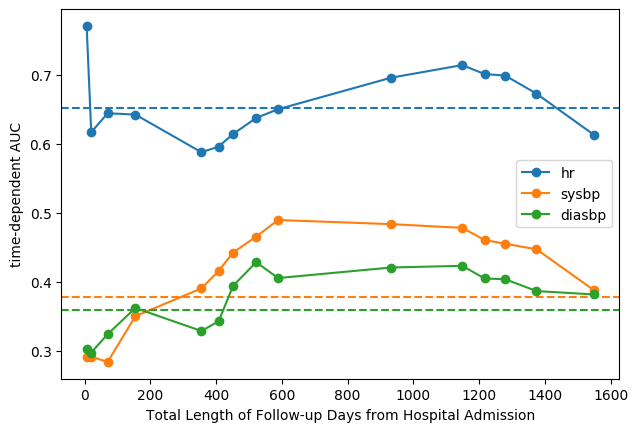

In [95]:
from sklearn.impute import SimpleImputer
num_columns = ['hr', 'sysbp', 'diasbp']
imputer = SimpleImputer().fit(X_train.loc[:, num_columns])
X_test_imputed = imputer.transform(X_test.loc[:, num_columns])

def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)
    
    plt.plot(times, auc, marker='o', color=color, label=label)
    plt.xlabel('Total Length of Follow-up Days from Hospital Admission')
    plt.ylabel('time-dependent AUC')
    plt.axhline(mean_auc, color=color, linestyle='--')
    plt.legend()
    
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(X_test_imputed[:, i], col, color='C{}'.format(i))
    ret = concordance_index_ipcw(y_train, y_test, X_test_imputed[:, i], tau = times[-1]);

**Interpretation**

1. The plot shows the estimated area under the time-dependent ROC at each time point

1. the average across all time points as dashed line.

1. Heart rate (hr) is overall the strongest predictor of overall survival

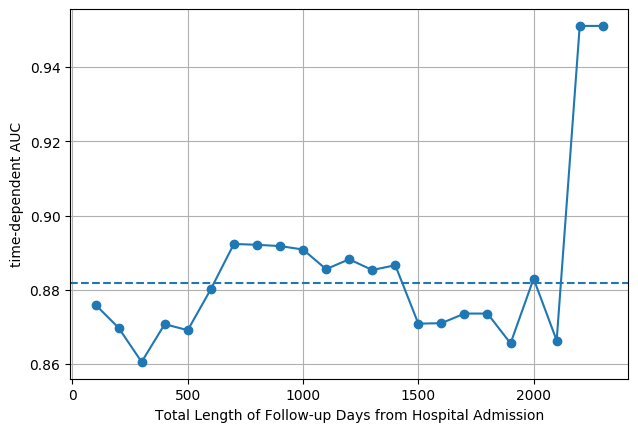

In [97]:
cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(bcx, bcy)
bc_times = np.arange(100, 2400, 100)
# estimate performance on training data, thus use `bcy` twice
bc_auc, bc_mean_auc = cumulative_dynamic_auc(bcy, bcy, cph.predict(bcx), bc_times)

plt.plot(bc_times, bc_auc, marker='o')
plt.axhline(bc_mean_auc, linestyle='--')
plt.xlabel('Total Length of Follow-up Days from Hospital Admission')
plt.ylabel('time-dependent AUC')
plt.grid(True);

**Interpretation**

1. The plot shows that the model is doing moderately well on average with an AUC of ~0.88 (dashed line). 

1. The performance on the test data increases up to 700 days from admission, remains high until 1,400 days

1. Then quickly drops thereafter. 

1. Thus, the model is most effective in predicting death in the medium-term.

# Step 4. Penalized Cox Models

In [98]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [99]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas: 
    cph.set_params(alpha=alpha)
    cph.fit(bcx, bcy)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_
    
coefficients = (pd.DataFrame
  .from_dict(coefficients)
  .rename_axis(index='feature', columns='alpha')
  .set_index(bcx.columns))

In [100]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], '.-', label=row.Index)
    
    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + ' ', 
            horizontalalignment = 'right',
            verticalalignment = 'center'
        )
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel('alpha')
    ax.set_ylabel('coefficient')

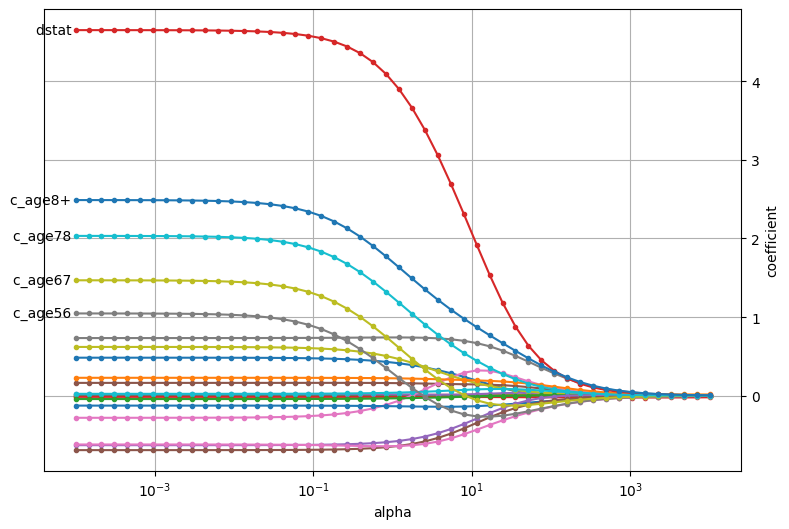

In [101]:
plot_coefficients(coefficients, n_highlight=5);

**Interpretation**

- if the penalty has a large weight (to the right), all coefficients are shrunk almost to zero
- It means that as the penalty’s weight is decreased, the coefficients’ value increases
- dstat (discharge status=death) quickly separate itself from the other coefficients: 
- It indicates that dstat is important predictive factor for time 

## LASSO

**Two limitations** 

1. Limitation with high-dimensional data: It cannot slelct more features than n of samples

1. Limitation with correlation:  LASOO randomly choose one feature from correlated features

In [102]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(bcx, bcy)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

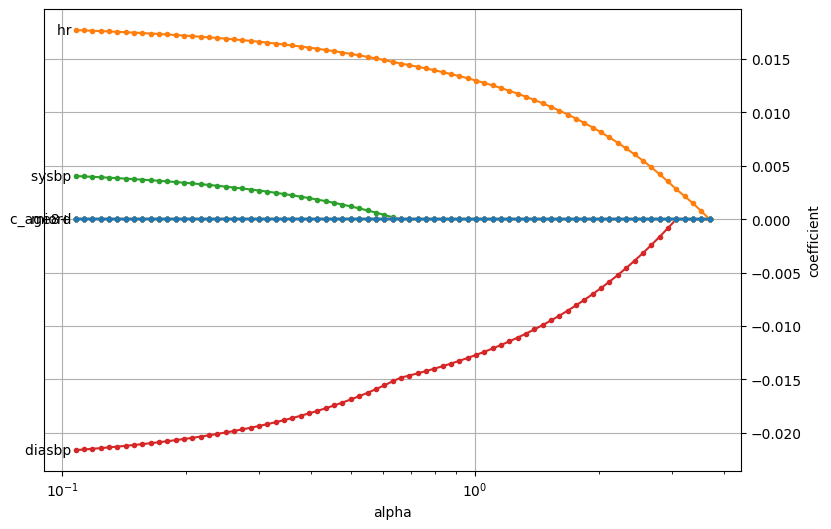

In [103]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=bcx.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)
plot_coefficients(coefficients_lasso, n_highlight=5);

**Interpretation**

1. The figure shows that the LASSO penalty selects a small subset of features for large alpha (to the right) with only two features (heart rate and diastolic BP)

1. As alpha decreases (to the left), more and more features become active and are assigned a non-zero coefficient 

1. Diastolic BP stands out, indicating its importance in heart attack,

## Elastic Net

In [104]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(bcx, bcy)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

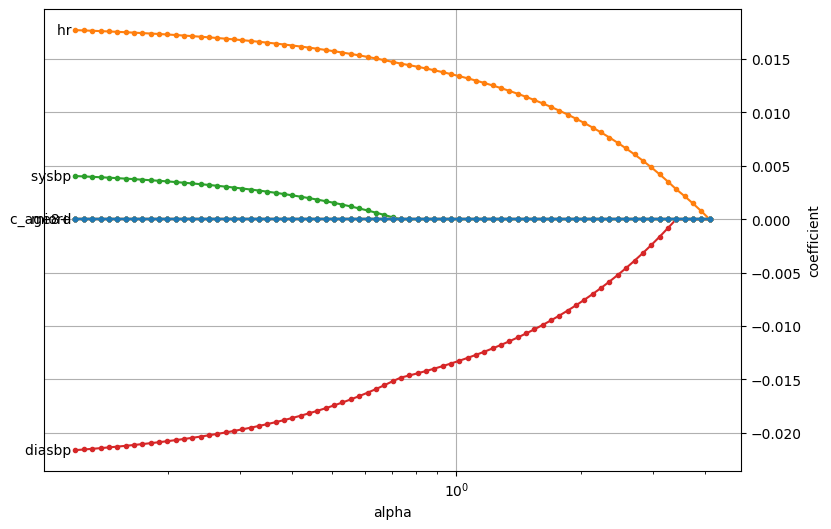

In [105]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, 
    index=bcx.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)
plot_coefficients(coefficients_elastic_net, n_highlight=5)

## Choosing penalty strength α

In [106]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
warnings.simplefilter('ignore', ConvergenceWarning)
coxnet_pipe.fit(bcx, bcy)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [107]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(bcx, bcy)

cv_results = pd.DataFrame(gcv.cv_results_)

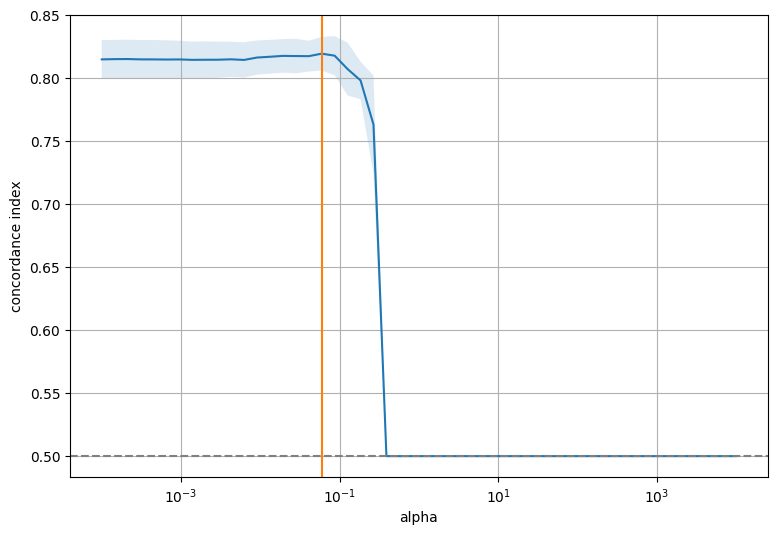

In [108]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean-std, mean+std, alpha=0.15)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('concordance index')
ax.axvline(gcv.best_params_['coxnetsurvivalanalysis__alphas'][0], c='C1')
ax.axhline(0.5, color='grey', linestyle='--')
ax.grid(True);

**Interpretation**

1. x-axis shows that large alpha sets all coefficients to zero

1. where y-axis indicates by the 0.5 concordance index of a purely random model. 

1. The best spot is alpha=0.1.where concordance index is the largest

Number of non-zero coefficients: 7


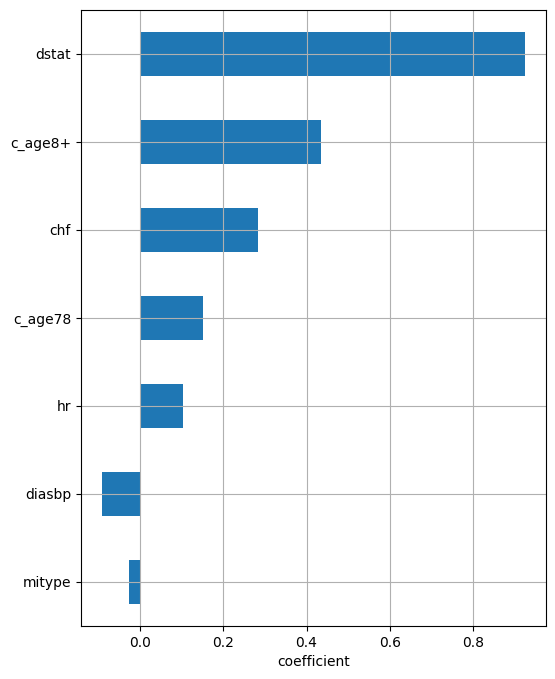

In [109]:
best_model = gcv.best_estimator_.named_steps['coxnetsurvivalanalysis']
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=bcx.columns,
    columns=['coefficient']
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print('Number of non-zero coefficients: {}'.format(non_zero))

non_zero_coefs = best_coefs.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').index
_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel('coefficient')
ax.grid(True);

**Interpretation**

1. The model selected a total of 7 features

1. Discharge status=death is the most important one, followed by age (80+), heart rate, diastolic BP, and MI type

## Survival and Cumulative Hazard Function

In [110]:
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(bcx, bcy)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.05963623316594643],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

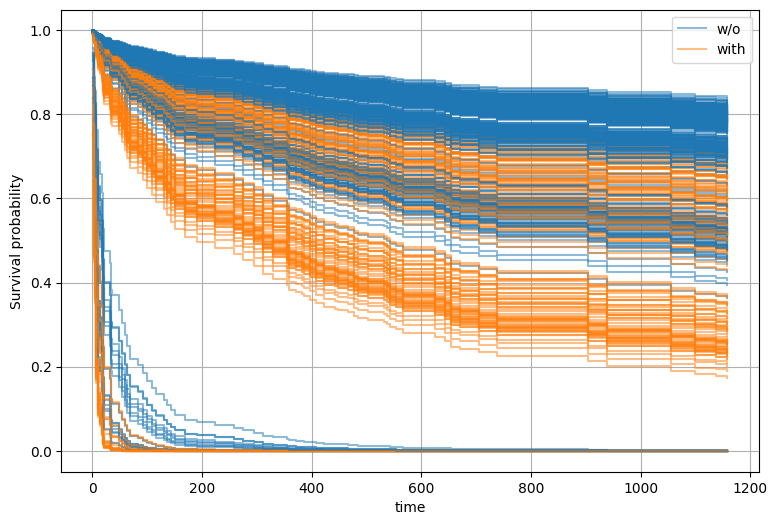

In [175]:
surv_fns = coxnet_pred.predict_survival_function(bcx)

time_points = np.quantile(bcy['lenfol'], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, bcx.loc[:, 'chf'].astype(int)):
    line, = ax.step(time_points, fn(time_points), where='post',
                   color='C{:d}'.format(label), alpha=0.5)
    if len(legend_handles) <= label:
        name = 'with CHF' if label == 1 else 'w/o CHF'
        legend_labels.append(name)
        legend_handles.append(line)
        
ax.legend(legend_handles, legend_labels)
ax.set_xlabel('Total Length of Follow-up Days from Hospital Admission')
ax.set_ylabel('Survival probability')
ax.grid(True);

# Step 5. Random Survival Forests

## Training

In [138]:
rsf = RandomSurvivalForest(n_estimators=1000, 
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features='sqrt',
                           n_jobs=-1,
                           random_state=20)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [139]:
rsf.score(X_test, y_test)

0.7929411764705883

## Permutation-based Feature Importance

In [145]:
feature=X_train.columns.tolist()

In [149]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rsf, n_iter=15, random_state=20)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature)

Weight,Feature
0.0951 ± 0.0371,dstat
0.0826 ± 0.0539,c_age8+
0.0114 ± 0.0116,hr
0.0094 ± 0.0271,chf
0.0064 ± 0.0070,c_age78
0.0030 ± 0.0022,male
0.0022 ± 0.0019,c_bmi3
0.0014 ± 0.0063,sysbp
0.0013 ± 0.0037,miord
0.0010 ± 0.0045,mitype


**Interpretation**
<br>
- As similar to previous other models, 
- discharge status (dstat) is the most important feature, 
- followed by age (80+), heart rate, having CHF, and age 70-80

## Gradient Boosted Models

### Base Learners

### Losses 

Cox’s Partial Likelihood

In [151]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

In [190]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print("Concordance Index: ", round(cindex, 3))

Concordance Index:  0.801


**Interpretation**
<br>
- This model achieves a concordance index of 0.801 on the test data

### The relationship between the model performance and no of estimators

In [153]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

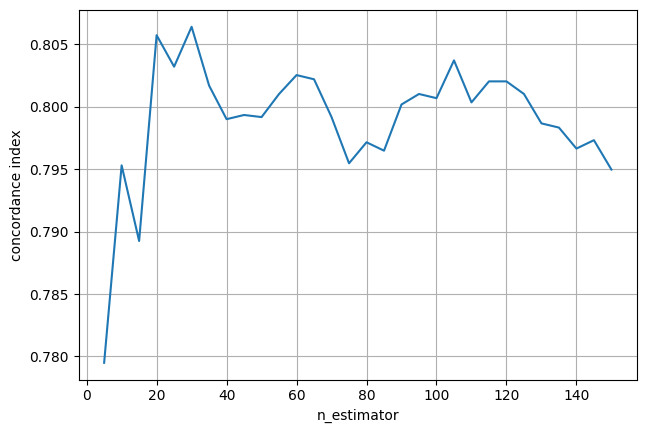

In [154]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel('n_estimator')
plt.ylabel('concordance index')
plt.grid(True);

**Interpretation**
<br>
- the performance quickly improves, but also that the performance starts to decrease if the ensemble becomes too big
<br>
- Best: n_estimator=20

In [155]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    learning_rate=1.0, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

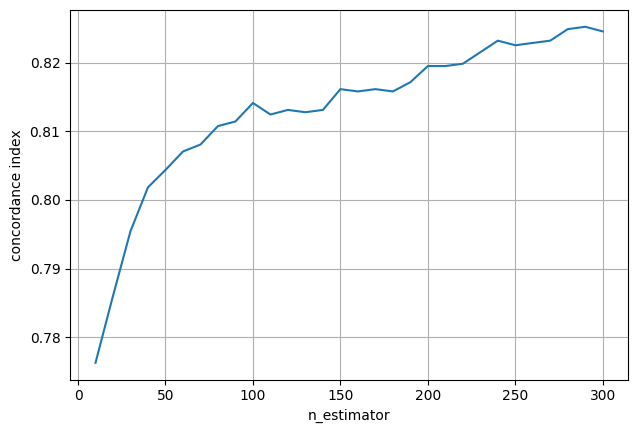

In [156]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel('n_estimator')
plt.ylabel('concordance index')
plt.grid(True);

In [158]:
coef = pd.Series(est_cph_ls.coef_, ['Intercept'] + X_train.columns.tolist())

print('Number of non-zero coefficients:', (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 19


dstat      4.37
c_age8+    1.59
c_age78    1.05
chf        0.79
sho       -0.51
c_bmi4    -0.48
c_age67    0.44
av3        0.39
c_bmi2    -0.39
c_bmi3    -0.33
male       0.26
year       0.18
afb        0.13
miord      0.13
c_age56   -0.12
mitype    -0.05
los       -0.02
diasbp    -0.01
hr         0.01
dtype: float64

## Accelerated Failure Time Model

In [189]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss='ipcwls', n_estimators=300, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print("Concordance index: ", round(cindex, 3))

Concordance index:  0.809


## Regularization

In [161]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    'no regularization': GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, max_depth=1, random_state=0
    ),
    'learning rate': GradientBoostingSurvivalAnalysis(
        learning_rate=0.1, max_depth=1, random_state=0
    ),
    'dropout': GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0
    ),
    'subsample': GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0
    ),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex=est.score(X_test, y_test)
        scores_reg[name].append(cindex)
        
scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

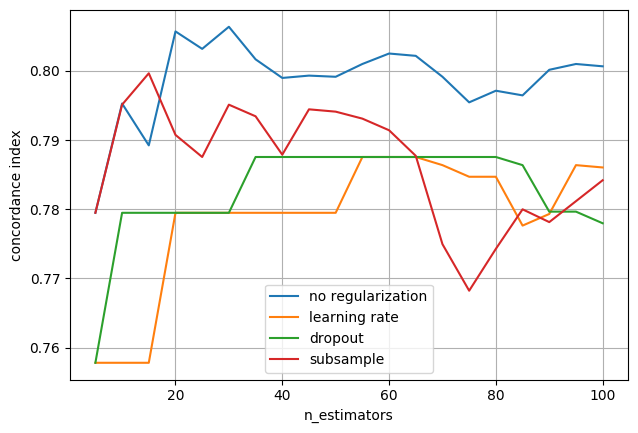

In [162]:
ax = scores_reg.plot(xlabel='n_estimators', ylabel='concordance index')
ax.grid(True);

**Interpretation**
<br>
1. Using dropout or a learning rate are most effective in avoiding overfitting. 
1. Moreover, the dropout and ensemble size are strongly connected.
1. Therefore, use a relatively small dropout and select the number of estimators via early stopping. 

In [163]:
class EarlyStoppingMonitor:
    
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1
        
    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False
        
        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])
        
        if improvement > 1e-6:
            self._best_step = iteration
            return False
        
        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement
    
est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.5,
    max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)
est_early_stopping.fit(X_train, y_train, monitor=monitor)

print('Fitted base learners:', est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print('Performance on test set', round(cindex, 3))

Fitted base learners: 322
Performance on test set 0.793


**Interpretation**
<br>
1. The monitor looks at the average improvement of the last 25 iterations, and if it was negative for the last 50 iterations, it will abort training. 
<br>
1. In this case, this occurred after 119 iterations. 

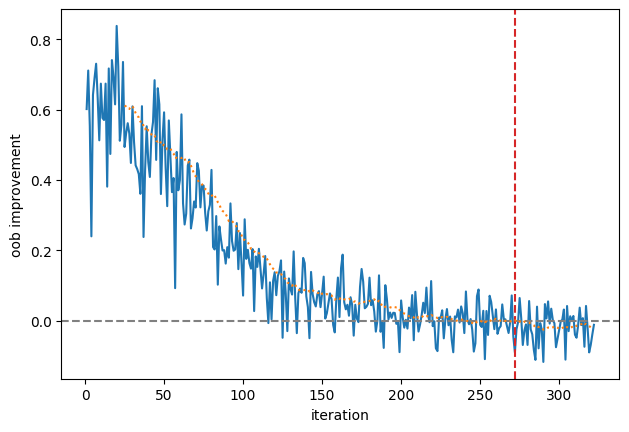

In [164]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_,
    index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel='iteration', ylabel='oob improvement')
ax.axhline(0.0, linestyle='--', color='gray')
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle='--', color='C3')

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=':')

**Interpretation of the figure**
<br>
1. The plot shows the relationship between the improvement  and no of iteration
<br>
1. After 119 iteration, little improvement.

# Linear Survival Support Vector Machine

In [165]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM
sns.set_style("whitegrid")

In [166]:
n_censored = bcy.shape[0] - bcy['fstat'].sum()
print('%.1f%% of records are censored' % (n_censored / bcy.shape[0] * 100))

57.0% of records are censored


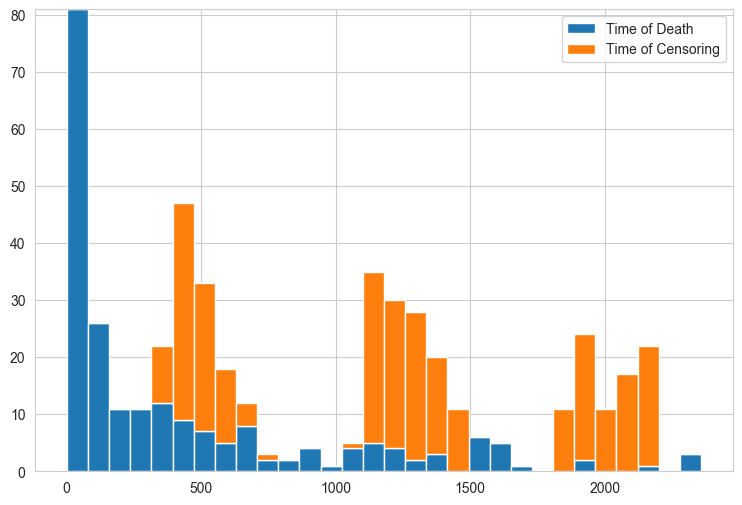

In [167]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((bcy['lenfol'][bcy['fstat']],
                               bcy['lenfol'][~bcy['fstat']]),
                               bins=30, stacked=True)
_ = plt.legend(patches, ['Time of Death', 'Time of Censoring']);

In [195]:
estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

In [168]:
def score_survival_model(model, bcx, bcy):
    prediction = model.predict(bcx)
    result = concordance_index_censored(bcy['fstat'], bcy['lenfol'], prediction)
    return result[0]

In [169]:
param_grid = {'alpha': 2. ** np.arange(-12, 13, 2)}
cv = ShuffleSplit(n_splits=100, test_size=0.5, random_state=0)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model, 
                   n_jobs=4, refit=False, 
                   cv=cv)

In [193]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
gcv = gcv.fit(bcx, bcy)

In [194]:
round(gcv.best_score_, 3), gcv.best_params_

(0.811, {'alpha': 4.0})

In [172]:
def plot_performance(gcv):
    n_splits=gcv.cv.n_splits
    cv_scores={'alpha': [], 'test_score': [], 'split': []}
    order = []
    for i, params in enumerate(gcv.cv_results_['params']):
        name = '%.5f' % params['alpha']
        order.append(name)
        for j in range(n_splits):
            vs = gcv.cv_results_['split%d_test_score' % j][i]
            cv_scores['alpha'].append(name)
            cv_scores['test_score'].append(vs)
            cv_scores['split'].append(j)
    df = pd.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x='alpha', y='test_score', data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation('vertical')

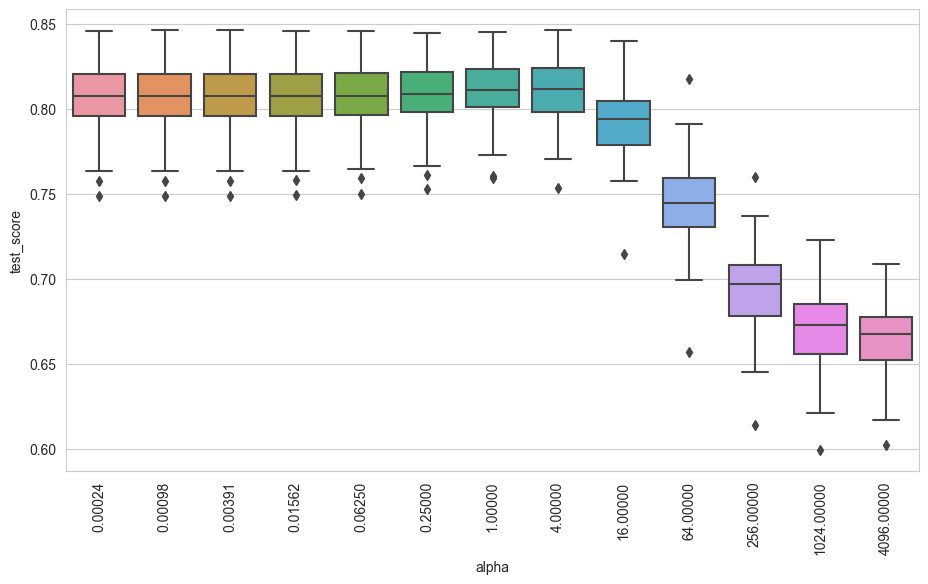

In [185]:
plot_performance(gcv)

**Interpretation**
<br>
- The model seems to be relative robust with alpha <4 for this dataset. 
<br>
- The model is the best (Harrell’s concordance index=0.811) when alpha is 4.0

In [196]:
estimator.set_params(**gcv.best_params_)
estimator.fit(bcx, bcy)

FastSurvivalSVM(alpha=4.0, max_iter=1000, optimizer='avltree', random_state=0,
                tol=1e-05)

In [197]:
pred = estimator.predict(bcx.iloc[:2])
print(np.round(pred, 3))
print(bcy[:2])

[0.967 0.27 ]
[(False, 2178.) (False, 2172.)]


**Interpretation**
<br>
1. prediction denotes risk score
<br>
1. The 1st print shows risk scores of two patients
<br>
1. The first patent has 0.967 risk score, fstat=False, lenfol=2,178 days
<br>
1. The 2nd patient has lower risk score, 0.27, though fstat and lenfol are similar. 

## Regression Objective

In [176]:
y_log_t = bcy.copy()
y_log_t['lenfol'] = np.log1p(bcy['lenfol'])

In [200]:
ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
ref_estimator.fit(bcx, y_log_t)

cindex = concordance_index_censored(
    bcy['fstat'],
    bcy['lenfol'],
    -ref_estimator.predict(bcx),
)
print("concordance_index_censored: ", round(cindex[0], 3))

concordance_index_censored:  0.558


In [178]:
pred_log = ref_estimator.predict(bcx.iloc[:2])
pred_y = np.expm1(pred_log)
print(np.round(pred_y, 3))

[282.254  61.921]


**Interpretation**
<br>
- The risk of the 1st patient os much higher than the 2nd patient, same as the above

## Kernel Survival Support Vector Machine

In [180]:
from sksurv.kernels import clinical_kernel
from sksurv.svm import FastKernelSurvivalSVM

In [181]:
kernel_matrix = clinical_kernel(bcx)

In [182]:
kssvm = FastKernelSurvivalSVM(optimizer='rbtree', kernel='precomputed', random_state=0)

kgcv = GridSearchCV(kssvm, param_grid, scoring=score_survival_model, n_jobs=4, refit=False, cv=cv)

In [ ]:
kgcv = kgcv.fit(kernel_matrix, bcy)

In [186]:
round(kgcv.best_score_, 3), kgcv.best_params_

(0.812, {'alpha': 0.015625})

**Interpretation**
<br>
- When alpha is 0.016625, the model achieves the best (C-index=0.812)

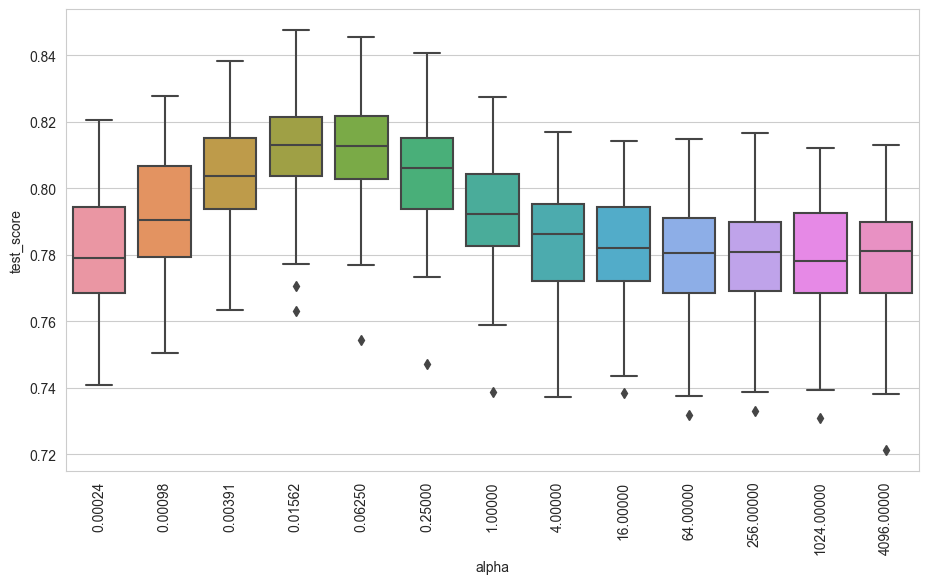

In [187]:
plot_performance(kgcv)

**Reference**
<br>
https://scikit-survival.readthedocs.io/en/stable/user_guide/
<br>
https://www.youtube.com/watch?v=PH2o_KVF7Jw